Uploaded AAPL.csv, JPM.csv, NVDA.csv and SPY.csv manually to colab.

Starting with AAPL.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from itertools import product
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
import gc

# 1 year:

# **AAPL:**

# Period 1:


Fold 1 - Train: 2012-01-01 to 2014-12-31 | Test: 2015-01-01 to 2015-12-31
Best ETS config: trend=mul, seasonal=add, sp=22, damped=True, RMSE=2.0960
Fold 1 Metrics:
  RMSE: 2.0960
  MAE:  1.8299
  MAPE: 0.0672
  R2:   -0.5485


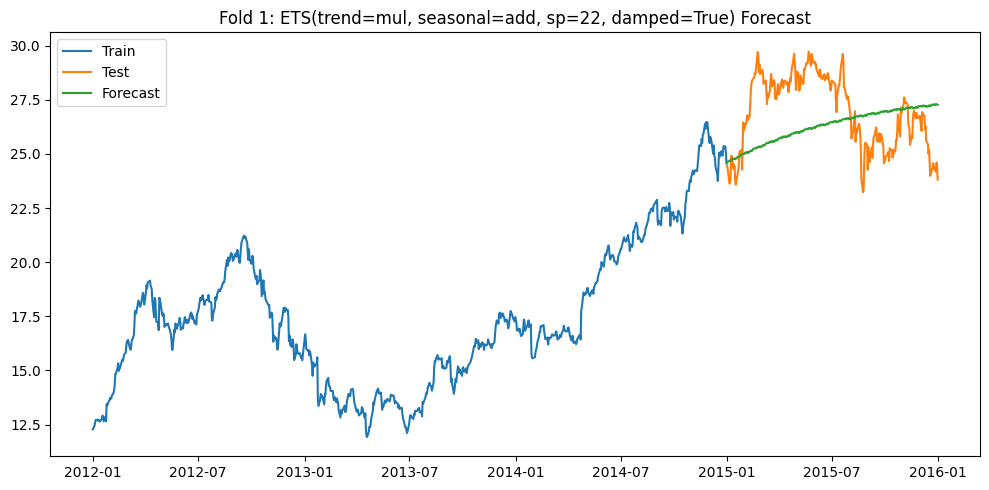


Fold 2 - Train: 2013-01-01 to 2015-12-31 | Test: 2016-01-01 to 2016-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=False, RMSE=1.7170
Fold 2 Metrics:
  RMSE: 1.7170
  MAE:  1.3722
  MAPE: 0.0603
  R2:   0.1368


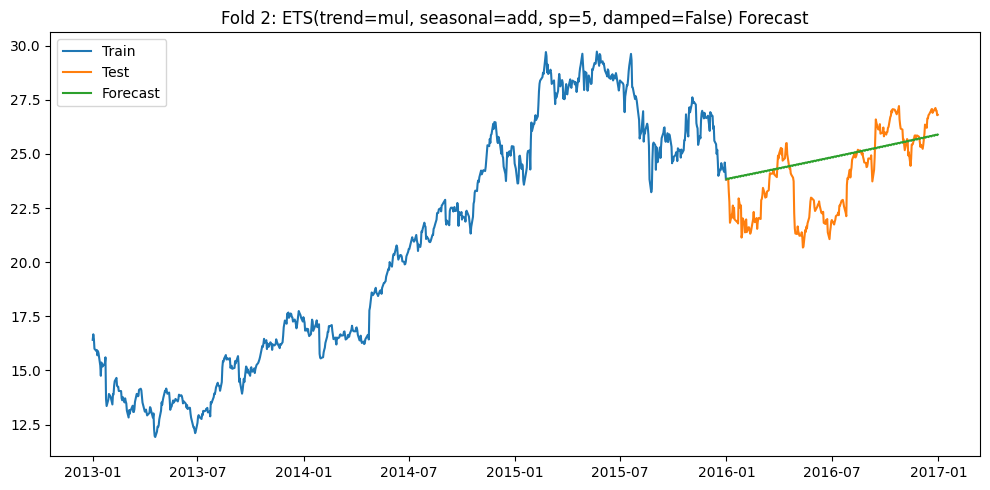


Fold 3 - Train: 2014-01-01 to 2016-12-31 | Test: 2017-01-01 to 2017-12-31
Best ETS config: trend=add, seasonal=mul, sp=22, damped=False, RMSE=7.2231
Fold 3 Metrics:
  RMSE: 7.2231
  MAE:  6.6663
  MAPE: 0.1833
  R2:   -2.9741


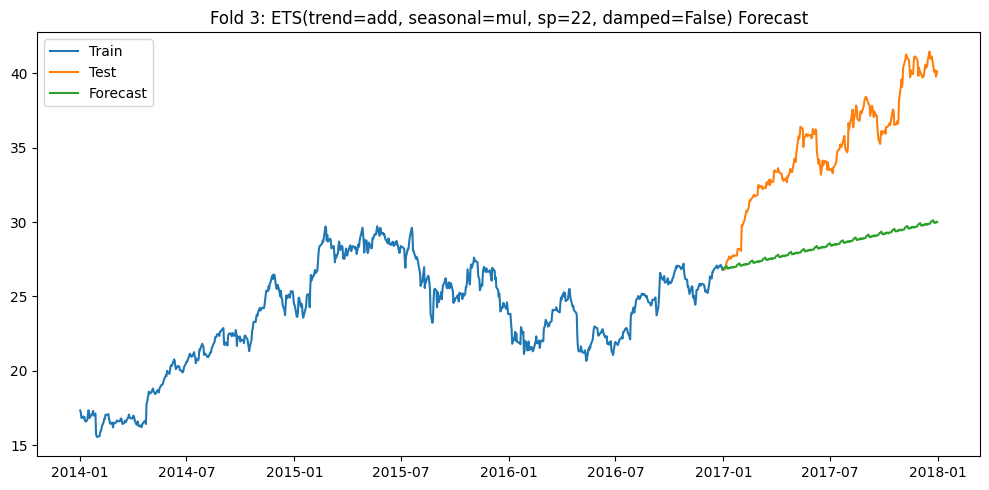

In [ ]:
# Load and preprocess data
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2012-01-01', '2014-12-31', '2015-01-01', '2015-12-31'),
    ('2013-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
    ('2014-01-01', '2016-12-31', '2017-01-01', '2017-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: mul, add, 22, false.

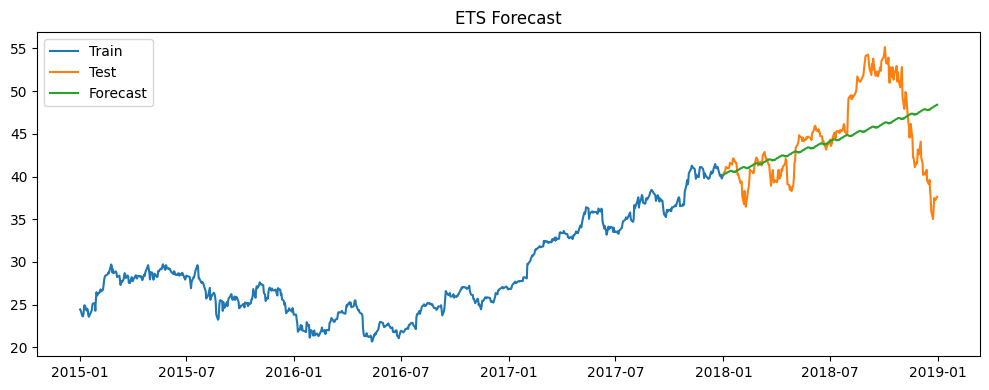

RMSE: 4.47, MAE: 3.33, MAPE: 0.07, R2: 0.19


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2015-01-01':'2017-12-31']['Close']
test = df.loc['2018-01-01':'2018-12-31']['Close']

model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=22, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


## Period 2:


Fold 1 - Train: 2015-01-01 to 2017-12-31 | Test: 2018-01-01 to 2018-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=True, RMSE=4.2757
Fold 1 Metrics:
  RMSE: 4.2757
  MAE:  3.1985
  MAPE: 0.0711
  R2:   0.2634


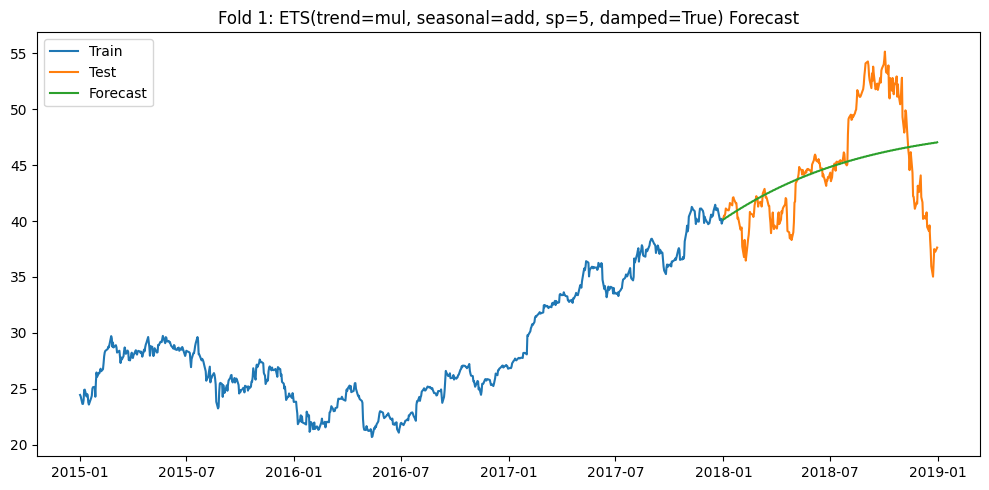


Fold 2 - Train: 2016-01-01 to 2018-12-31 | Test: 2019-01-01 to 2019-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=12.5212
Fold 2 Metrics:
  RMSE: 12.5212
  MAE:  10.2785
  MAPE: 0.1879
  R2:   -1.1077


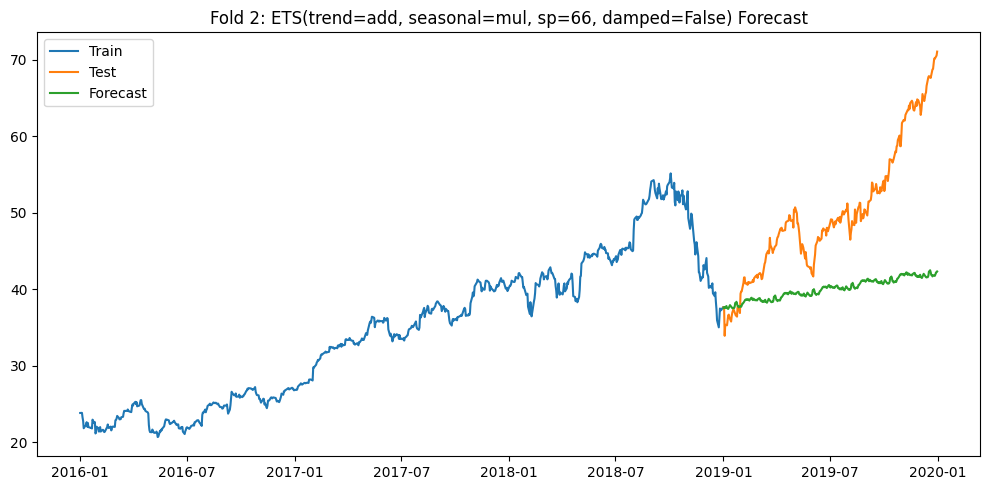


Fold 3 - Train: 2017-01-01 to 2019-12-31 | Test: 2020-01-01 to 2020-12-31
Best ETS config: trend=add, seasonal=add, sp=66, damped=False, RMSE=11.2125
Fold 3 Metrics:
  RMSE: 11.2125
  MAE:  9.0961
  MAPE: 0.1083
  R2:   0.7244


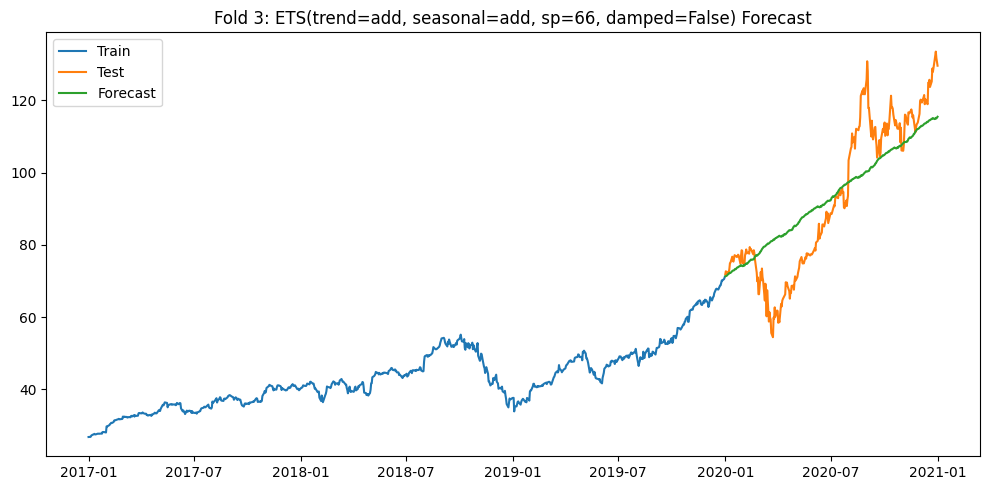

In [ ]:
# Load and preprocess data
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),
    ('2016-01-01', '2018-12-31', '2019-01-01', '2019-12-31'),
    ('2017-01-01', '2019-12-31', '2020-01-01', '2020-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: add add 66 false

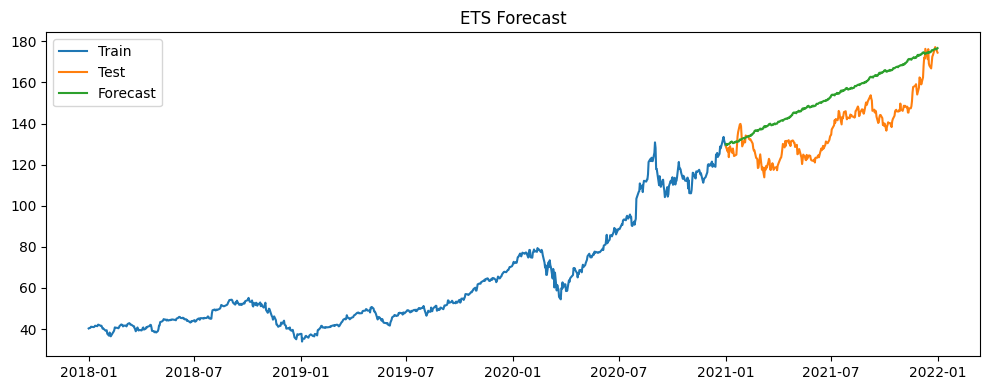

RMSE: 17.07, MAE: 15.26, MAPE: 0.11, R2: -0.39


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2018-01-01':'2020-12-31']['Close']
test = df.loc['2021-01-01':'2021-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# Period 3:


Fold 1 - Train: 2018-01-01 to 2020-12-31 | Test: 2021-01-01 to 2021-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=9.8359
Fold 1 Metrics:
  RMSE: 9.8359
  MAE:  7.8281
  MAPE: 0.0580
  R2:   0.5388


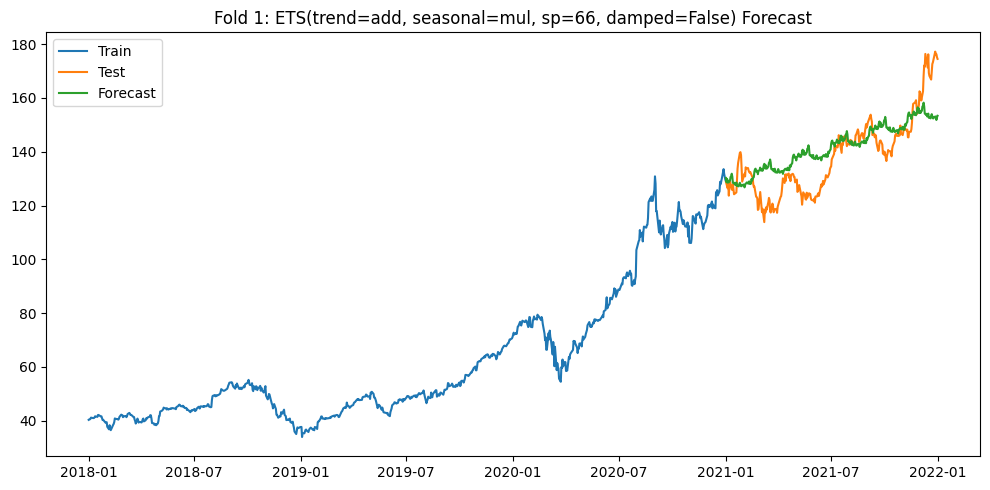


Fold 2 - Train: 2019-01-01 to 2021-12-31 | Test: 2022-01-01 to 2022-12-31
Best ETS config: trend=None, seasonal=mul, sp=5, damped=False, RMSE=25.2682
Fold 2 Metrics:
  RMSE: 25.2682
  MAE:  21.9351
  MAPE: 0.1518
  R2:   -2.9682


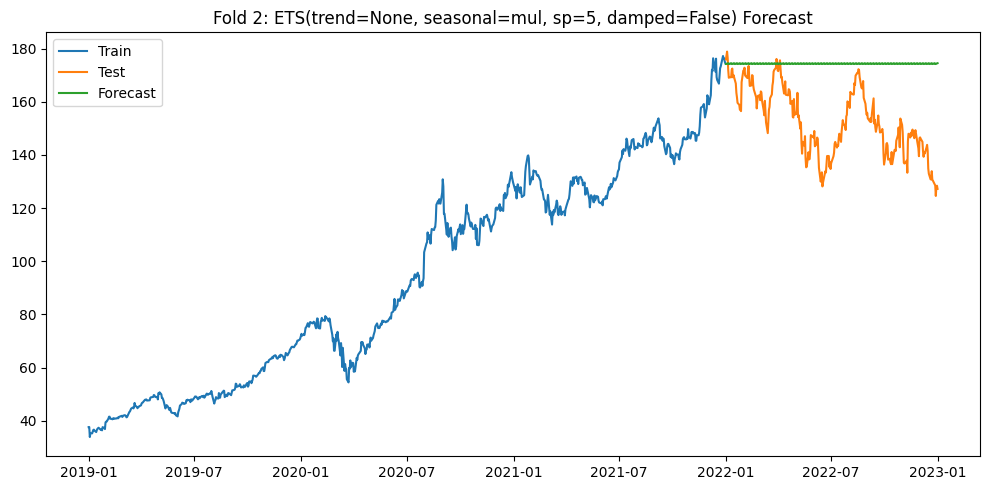


Fold 3 - Train: 2020-01-01 to 2022-12-31 | Test: 2023-01-01 to 2023-12-31
Best ETS config: trend=add, seasonal=mul, sp=5, damped=False, RMSE=37.2222
Fold 3 Metrics:
  RMSE: 37.2222
  MAE:  34.7535
  MAPE: 0.1969
  R2:   -3.4817


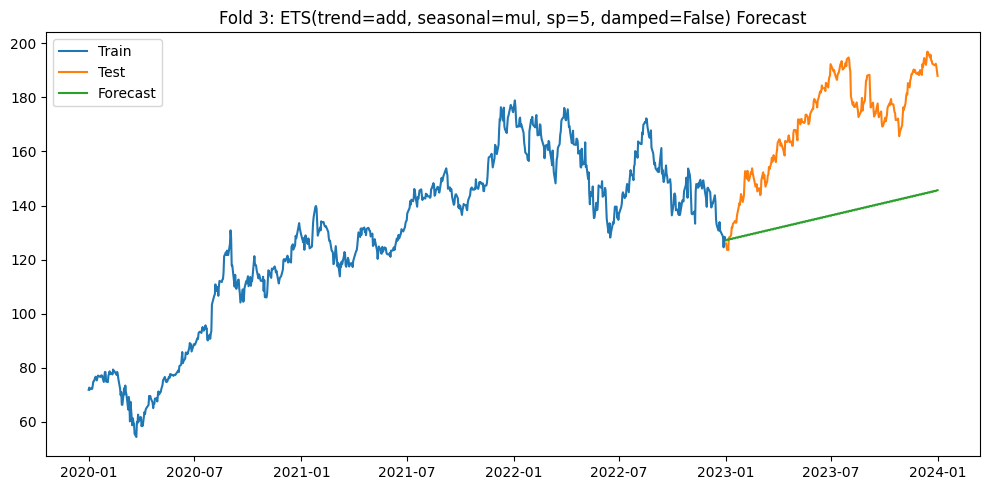

In [ ]:
# Load and preprocess data
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2018-01-01', '2020-12-31', '2021-01-01', '2021-12-31'),
    ('2019-01-01', '2021-12-31', '2022-01-01', '2022-12-31'),
    ('2020-01-01', '2022-12-31', '2023-01-01', '2023-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparam: add mul 5 false

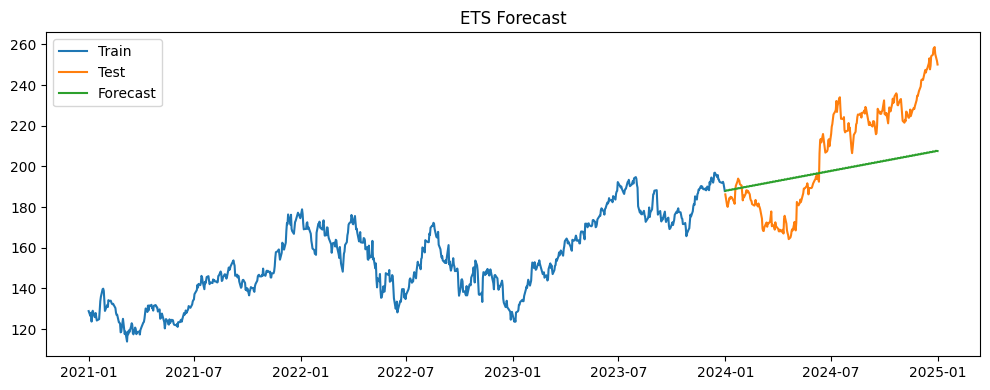

RMSE: 22.51, MAE: 19.58, MAPE: 0.09, R2: 0.23


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2021-01-01':'2023-12-31']['Close']
test = df.loc['2024-01-01':'2024-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# JPM:

# Period 1:


Fold 1 - Train: 2012-01-01 to 2014-12-31 | Test: 2015-01-01 to 2015-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=True, RMSE=2.9071
Fold 1 Metrics:
  RMSE: 2.9071
  MAE:  2.4563
  MAPE: 0.0499
  R2:   0.0669


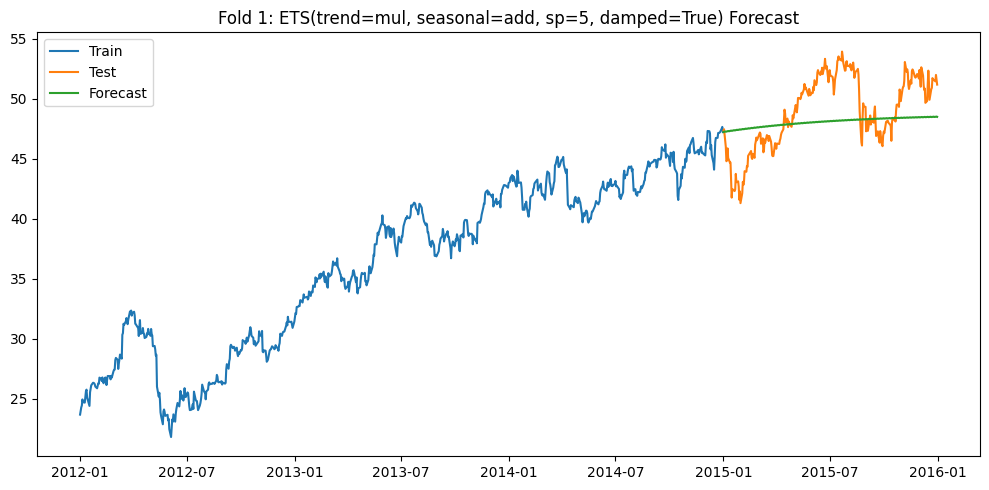


Fold 2 - Train: 2013-01-01 to 2015-12-31 | Test: 2016-01-01 to 2016-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=False, RMSE=5.6132
Fold 2 Metrics:
  RMSE: 5.6132
  MAE:  5.0409
  MAPE: 0.0982
  R2:   0.2667


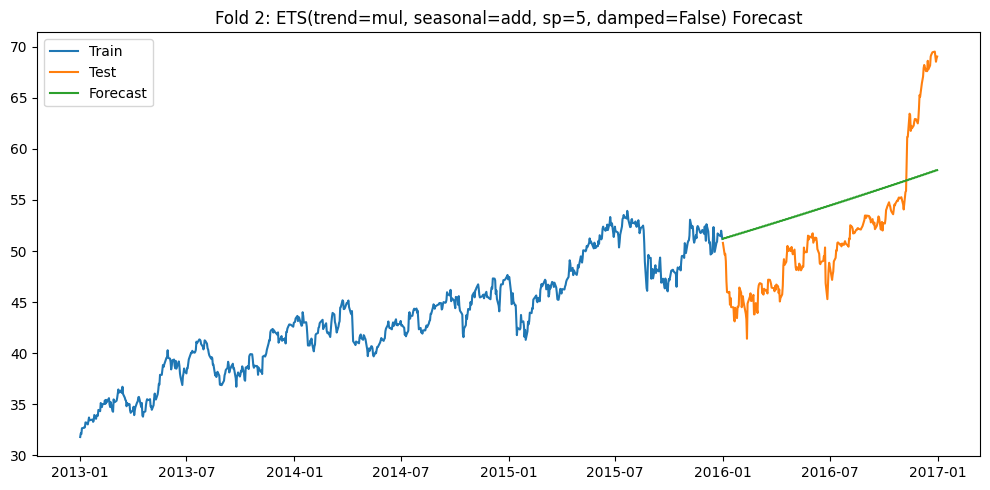


Fold 3 - Train: 2014-01-01 to 2016-12-31 | Test: 2017-01-01 to 2017-12-31
Best ETS config: trend=mul, seasonal=mul, sp=5, damped=False, RMSE=3.2937
Fold 3 Metrics:
  RMSE: 3.2937
  MAE:  2.7526
  MAPE: 0.0374
  R2:   0.6534


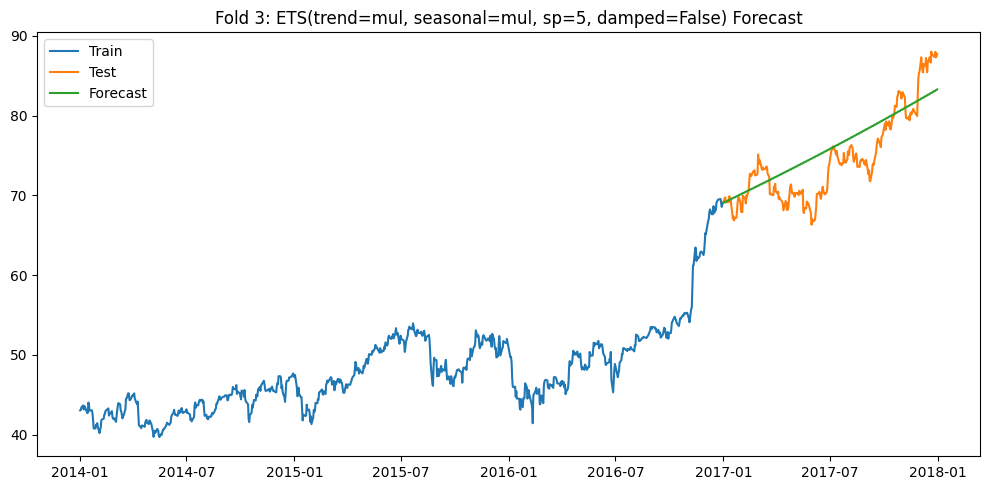

In [ ]:
# Load and preprocess data
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2012-01-01', '2014-12-31', '2015-01-01', '2015-12-31'),
    ('2013-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
    ('2014-01-01', '2016-12-31', '2017-01-01', '2017-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: mul, mul, 5, false.

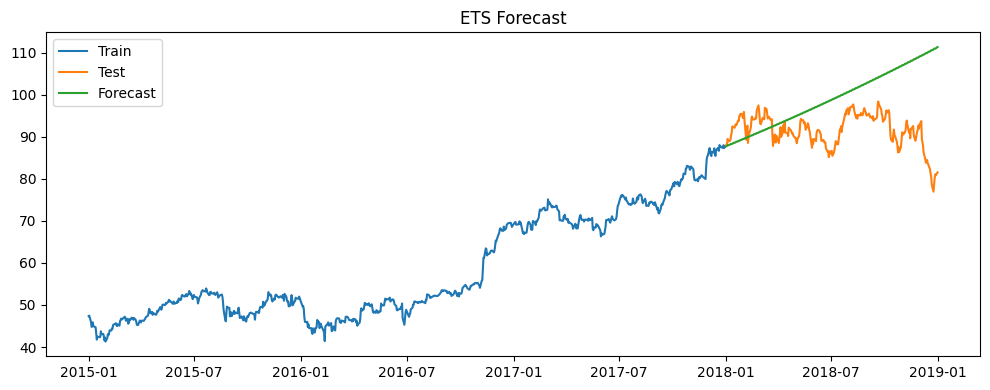

RMSE: 11.60, MAE: 9.00, MAPE: 0.10, R2: -7.71


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('JPM.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2015-01-01':'2017-12-31']['Close']
test = df.loc['2018-01-01':'2018-12-31']['Close']

model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


## Period 2:


Fold 1 - Train: 2015-01-01 to 2017-12-31 | Test: 2018-01-01 to 2018-12-31
Best ETS config: trend=mul, seasonal=add, sp=22, damped=True, RMSE=4.8984
Fold 1 Metrics:
  RMSE: 4.8984
  MAE:  3.6460
  MAPE: 0.0412
  R2:   -0.5518


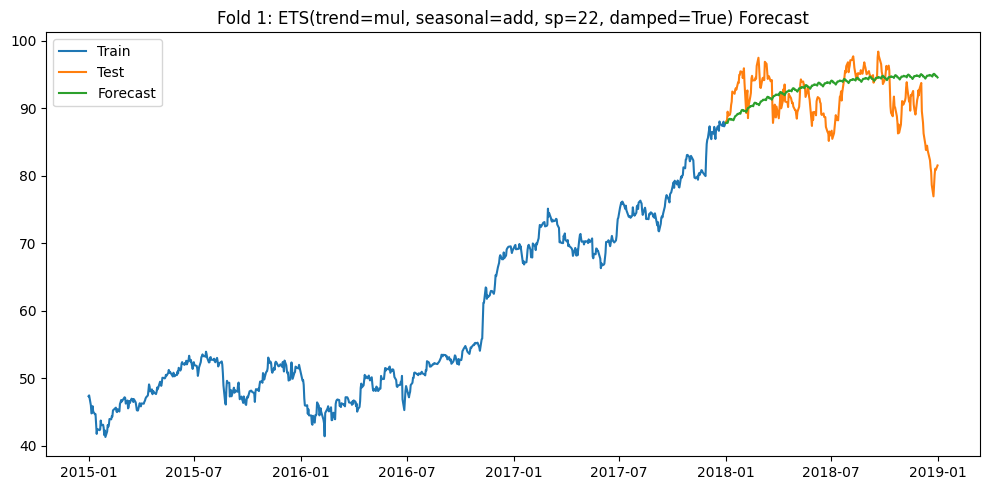


Fold 2 - Train: 2016-01-01 to 2018-12-31 | Test: 2019-01-01 to 2019-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=12.0406
Fold 2 Metrics:
  RMSE: 12.0406
  MAE:  9.6878
  MAPE: 0.0941
  R2:   -0.5530


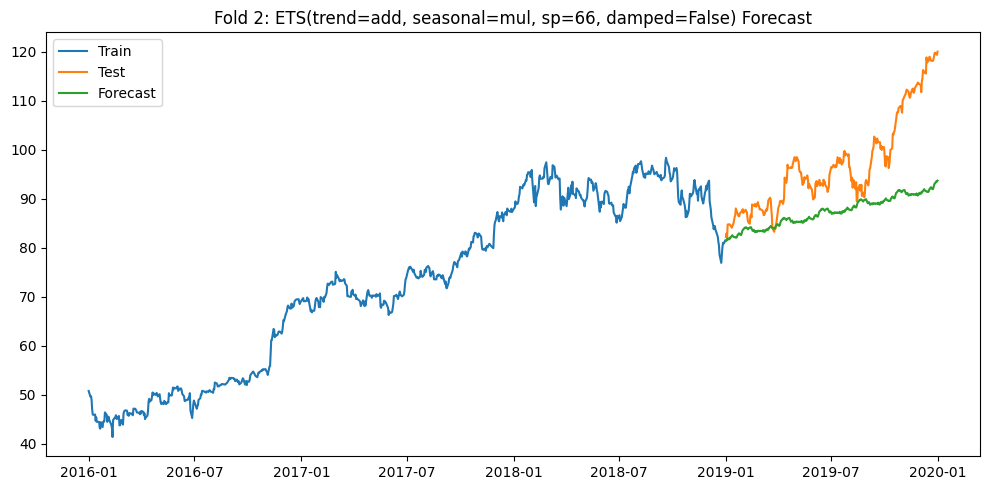


Fold 3 - Train: 2017-01-01 to 2019-12-31 | Test: 2020-01-01 to 2020-12-31
Best ETS config: trend=None, seasonal=mul, sp=66, damped=False, RMSE=28.6848
Fold 3 Metrics:
  RMSE: 28.6848
  MAE:  25.2527
  MAPE: 0.2945
  R2:   -3.3690


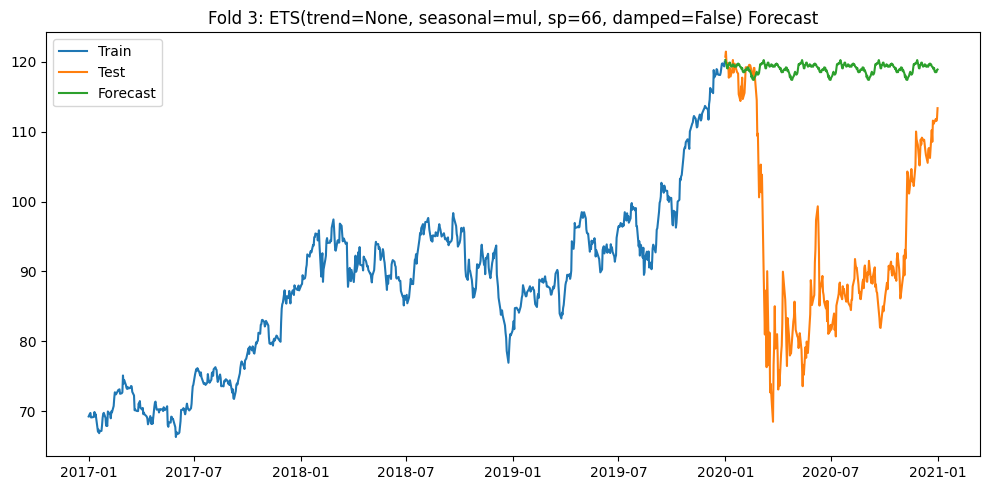

In [ ]:
# Load and preprocess data
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),
    ('2016-01-01', '2018-12-31', '2019-01-01', '2019-12-31'),
    ('2017-01-01', '2019-12-31', '2020-01-01', '2020-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: add mul 66 false

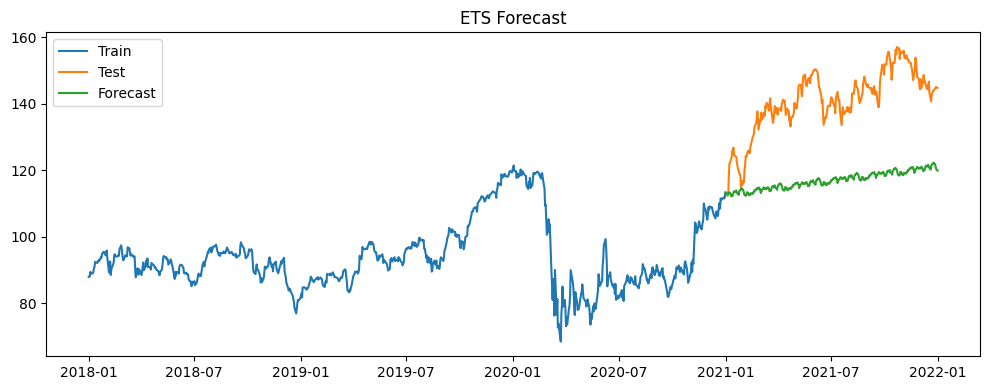

RMSE: 25.21, MAE: 23.97, MAPE: 0.17, R2: -5.99


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('JPM.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2018-01-01':'2020-12-31']['Close']
test = df.loc['2021-01-01':'2021-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# Period 3:


Fold 1 - Train: 2018-01-01 to 2020-12-31 | Test: 2021-01-01 to 2021-12-31
Best ETS config: trend=mul, seasonal=add, sp=22, damped=True, RMSE=5.0553
Fold 1 Metrics:
  RMSE: 5.0553
  MAE:  4.3620
  MAPE: 0.0309
  R2:   0.7191


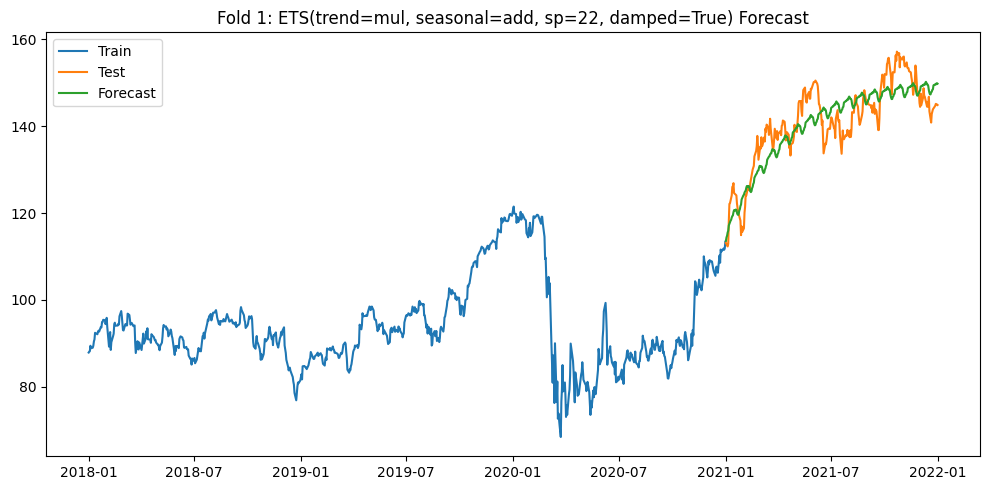


Fold 2 - Train: 2019-01-01 to 2021-12-31 | Test: 2022-01-01 to 2022-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=True, RMSE=25.1839
Fold 2 Metrics:
  RMSE: 25.1839
  MAE:  22.6627
  MAPE: 0.2014
  R2:   -2.8240


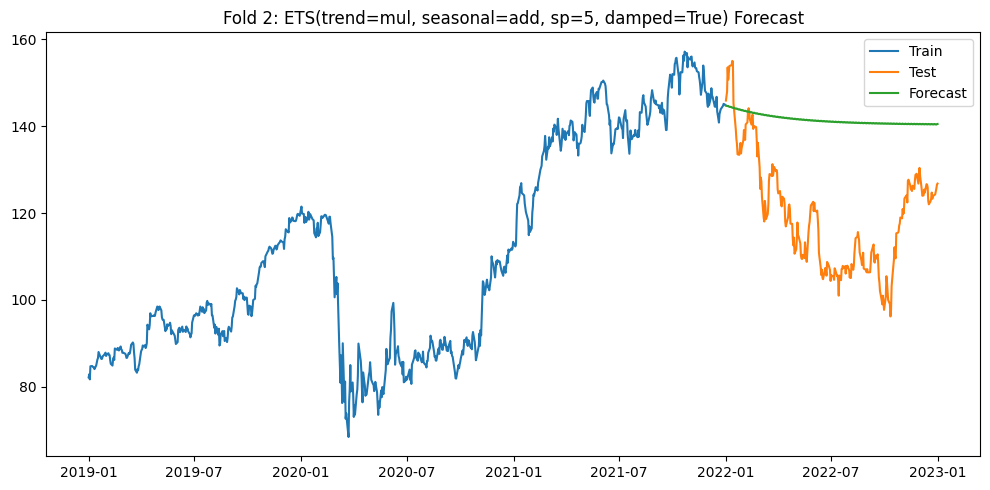


Fold 3 - Train: 2020-01-01 to 2022-12-31 | Test: 2023-01-01 to 2023-12-31
Best ETS config: trend=mul, seasonal=mul, sp=66, damped=False, RMSE=6.4796
Fold 3 Metrics:
  RMSE: 6.4796
  MAE:  5.3210
  MAPE: 0.0387
  R2:   0.5673


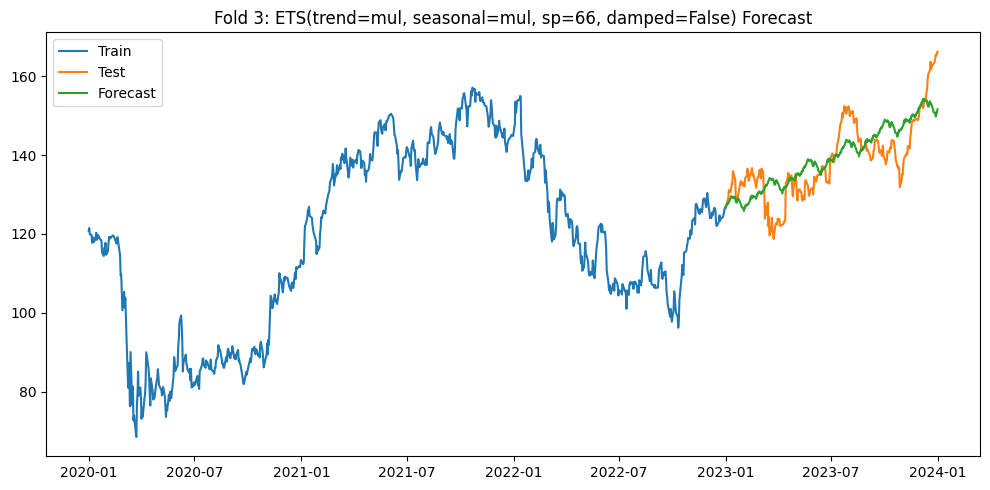

In [ ]:
# Load and preprocess data
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2018-01-01', '2020-12-31', '2021-01-01', '2021-12-31'),
    ('2019-01-01', '2021-12-31', '2022-01-01', '2022-12-31'),
    ('2020-01-01', '2022-12-31', '2023-01-01', '2023-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparam: mul mul 66 false

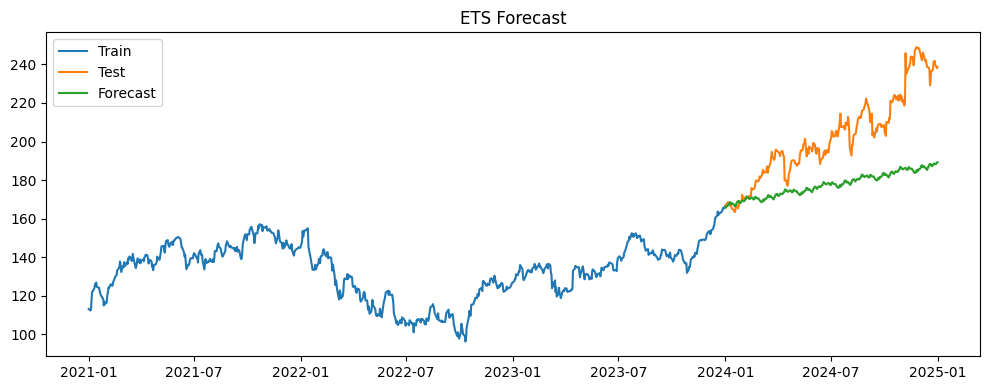

RMSE: 30.08, MAE: 25.15, MAPE: 0.12, R2: -0.80


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('JPM.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2021-01-01':'2023-12-31']['Close']
test = df.loc['2024-01-01':'2024-12-31']['Close']

model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# **NVDA:**

# Period 1:


Fold 1 - Train: 2012-01-01 to 2014-12-31 | Test: 2015-01-01 to 2015-12-31
Best ETS config: trend=mul, seasonal=add, sp=22, damped=False, RMSE=0.1035
Fold 1 Metrics:
  RMSE: 0.1035
  MAE:  0.0677
  MAPE: 0.1015
  R2:   -0.0182


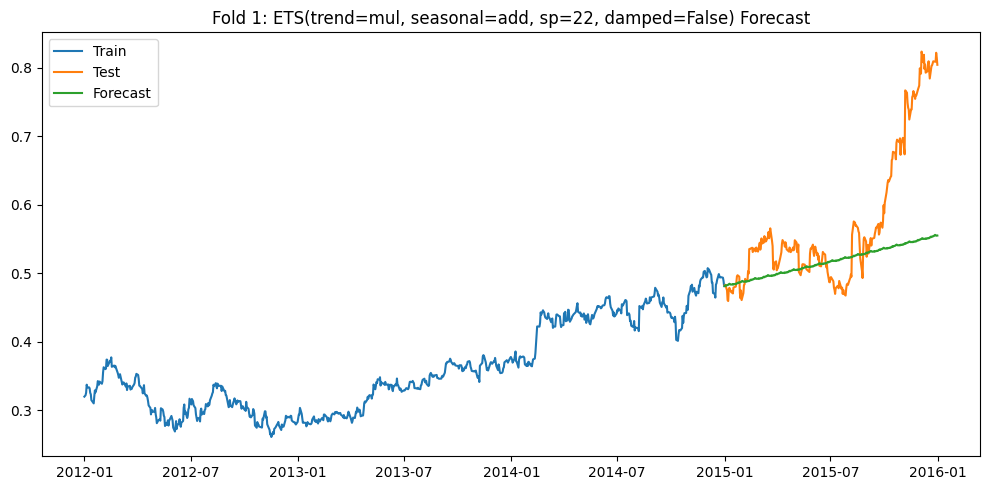


Fold 2 - Train: 2013-01-01 to 2015-12-31 | Test: 2016-01-01 to 2016-12-31
Best ETS config: trend=mul, seasonal=mul, sp=66, damped=False, RMSE=0.5418
Fold 2 Metrics:
  RMSE: 0.5418
  MAE:  0.3835
  MAPE: 0.2369
  R2:   0.0127


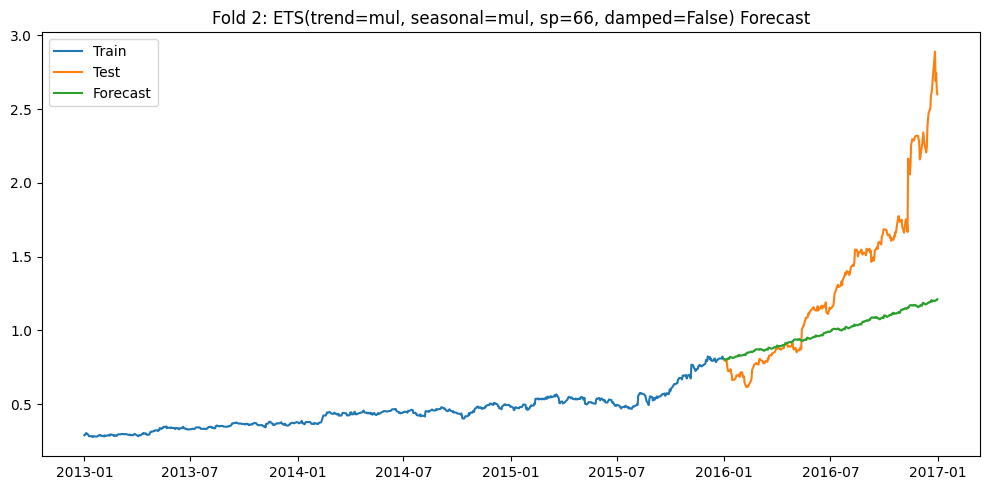


Fold 3 - Train: 2014-01-01 to 2016-12-31 | Test: 2017-01-01 to 2017-12-31
Best ETS config: trend=add, seasonal=mul, sp=5, damped=False, RMSE=0.3777
Fold 3 Metrics:
  RMSE: 0.3777
  MAE:  0.2823
  MAPE: 0.0905
  R2:   0.8407


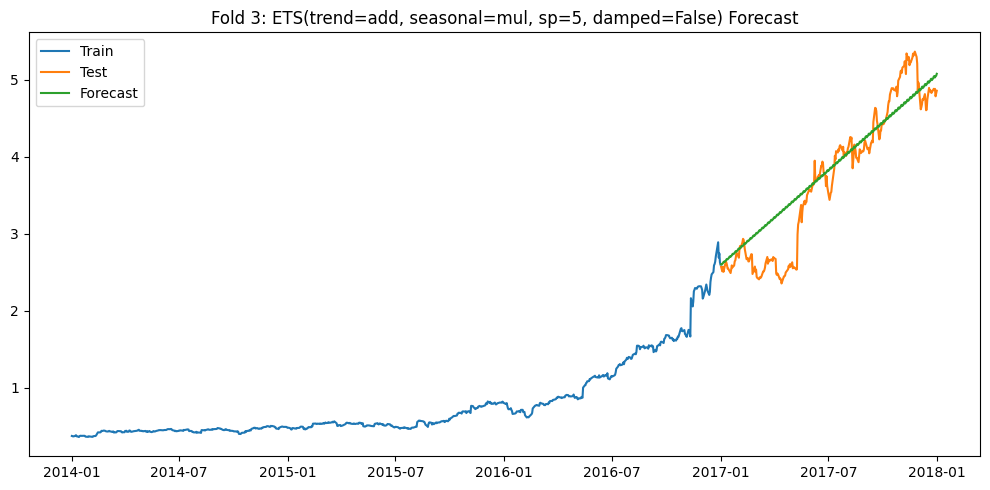

In [ ]:
# Load and preprocess data
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2012-01-01', '2014-12-31', '2015-01-01', '2015-12-31'),
    ('2013-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
    ('2014-01-01', '2016-12-31', '2017-01-01', '2017-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: add, mul, 5, false.

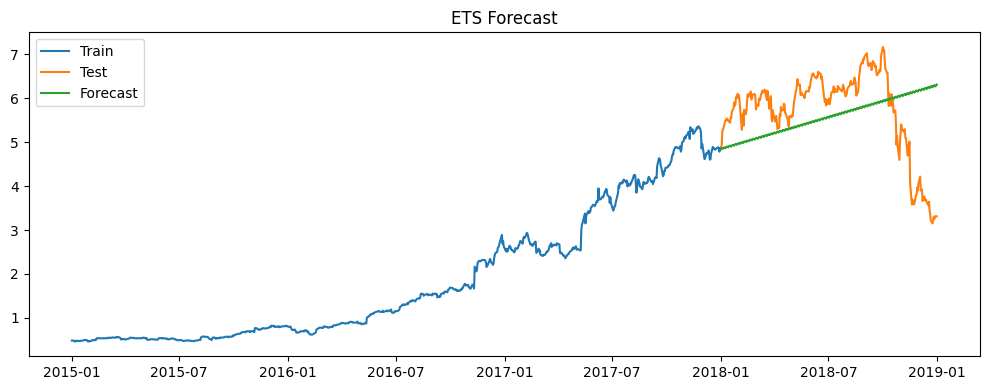

RMSE: 1.17, MAE: 0.94, MAPE: 0.19, R2: -0.58


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2015-01-01':'2017-12-31']['Close']
test = df.loc['2018-01-01':'2018-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


## Period 2:


Fold 1 - Train: 2015-01-01 to 2017-12-31 | Test: 2018-01-01 to 2018-12-31
Best ETS config: trend=add, seasonal=mul, sp=22, damped=True, RMSE=1.1009
Fold 1 Metrics:
  RMSE: 1.1009
  MAE:  0.9945
  MAPE: 0.1859
  R2:   -0.4072


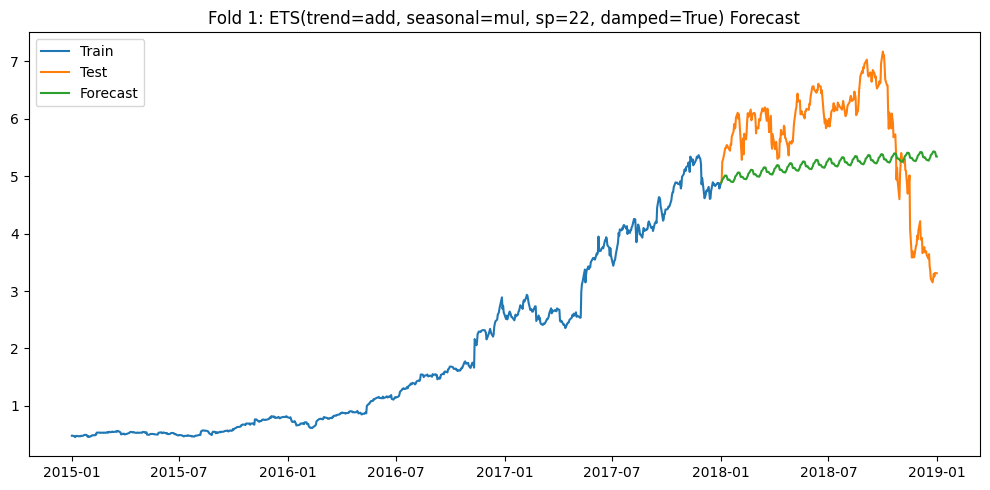


Fold 2 - Train: 2016-01-01 to 2018-12-31 | Test: 2019-01-01 to 2019-12-31
Best ETS config: trend=add, seasonal=add, sp=5, damped=False, RMSE=0.7783
Fold 2 Metrics:
  RMSE: 0.7783
  MAE:  0.6318
  MAPE: 0.1352
  R2:   -0.5220


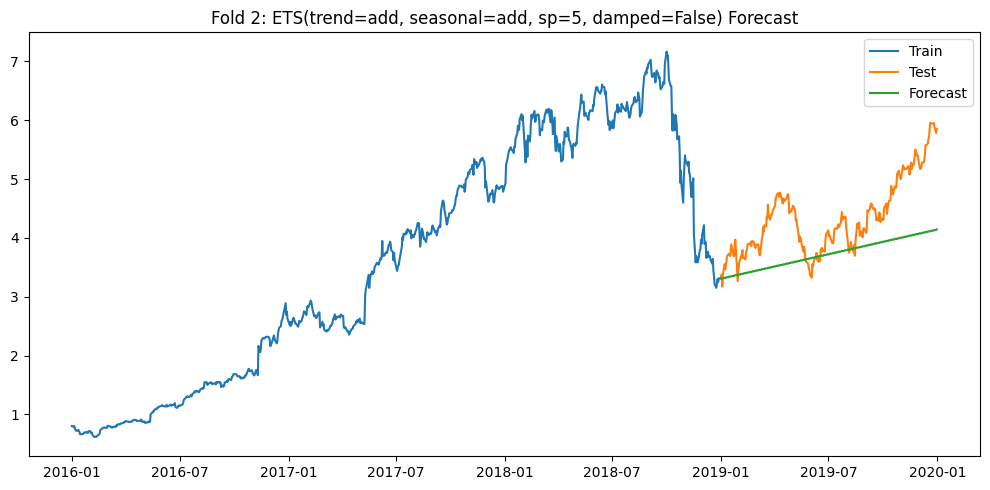


Fold 3 - Train: 2017-01-01 to 2019-12-31 | Test: 2020-01-01 to 2020-12-31
Best ETS config: trend=mul, seasonal=mul, sp=5, damped=False, RMSE=2.0793
Fold 3 Metrics:
  RMSE: 2.0793
  MAE:  1.6546
  MAPE: 0.1480
  R2:   0.4914


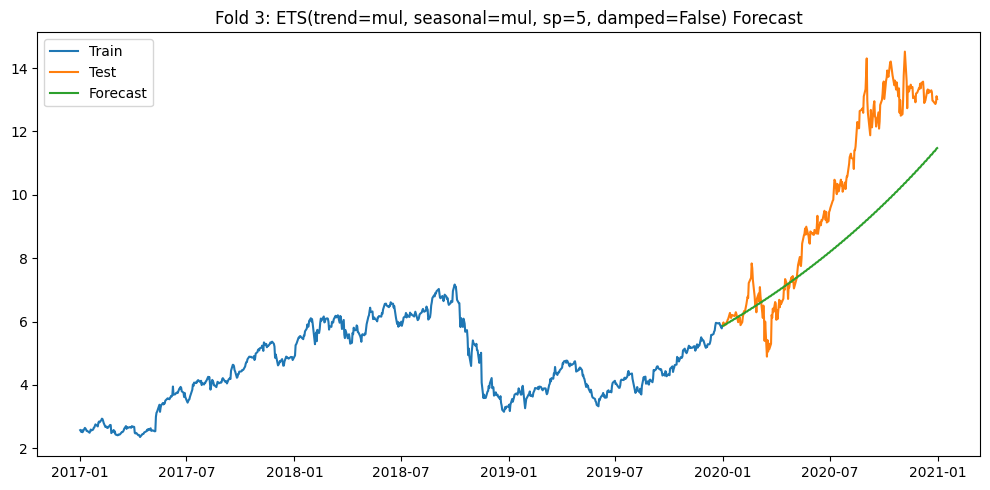

In [ ]:
# Load and preprocess data
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),
    ('2016-01-01', '2018-12-31', '2019-01-01', '2019-12-31'),
    ('2017-01-01', '2019-12-31', '2020-01-01', '2020-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: mul mul 5 false

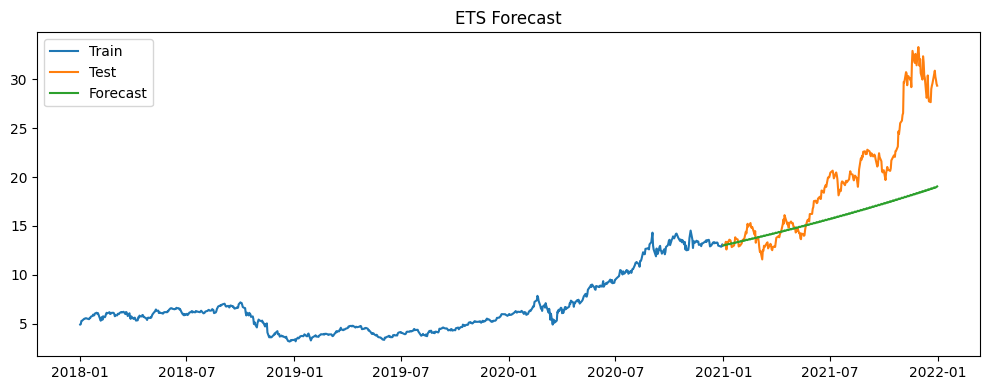

RMSE: 5.62, MAE: 3.96, MAPE: 0.17, R2: 0.08


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2018-01-01':'2020-12-31']['Close']
test = df.loc['2021-01-01':'2021-12-31']['Close']

model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# Period 3:


Fold 1 - Train: 2018-01-01 to 2020-12-31 | Test: 2021-01-01 to 2021-12-31
Best ETS config: trend=mul, seasonal=mul, sp=22, damped=False, RMSE=5.4272
Fold 1 Metrics:
  RMSE: 5.4272
  MAE:  3.8046
  MAPE: 0.1607
  R2:   0.1429


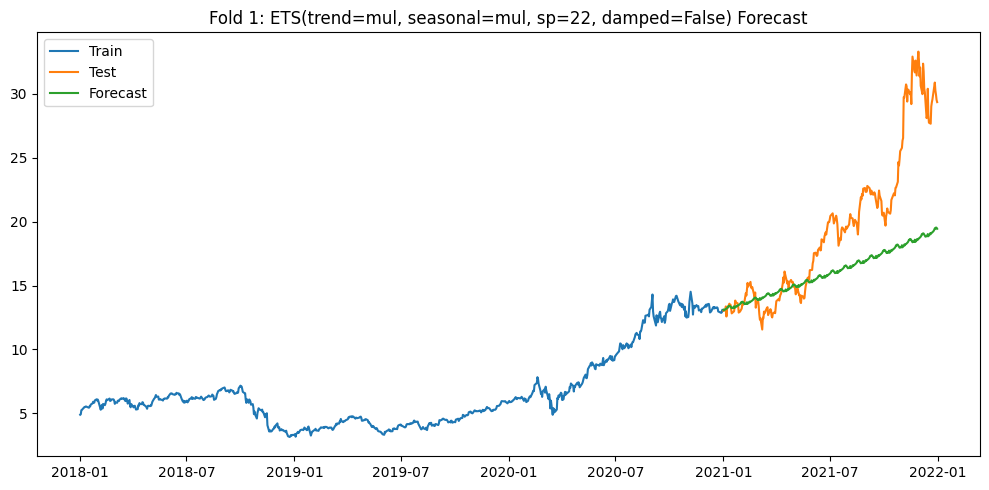


Fold 2 - Train: 2019-01-01 to 2021-12-31 | Test: 2022-01-01 to 2022-12-31
Best ETS config: trend=add, seasonal=add, sp=66, damped=True, RMSE=11.6552
Fold 2 Metrics:
  RMSE: 11.6552
  MAE:  10.7284
  MAPE: 0.6733
  R2:   -5.3599


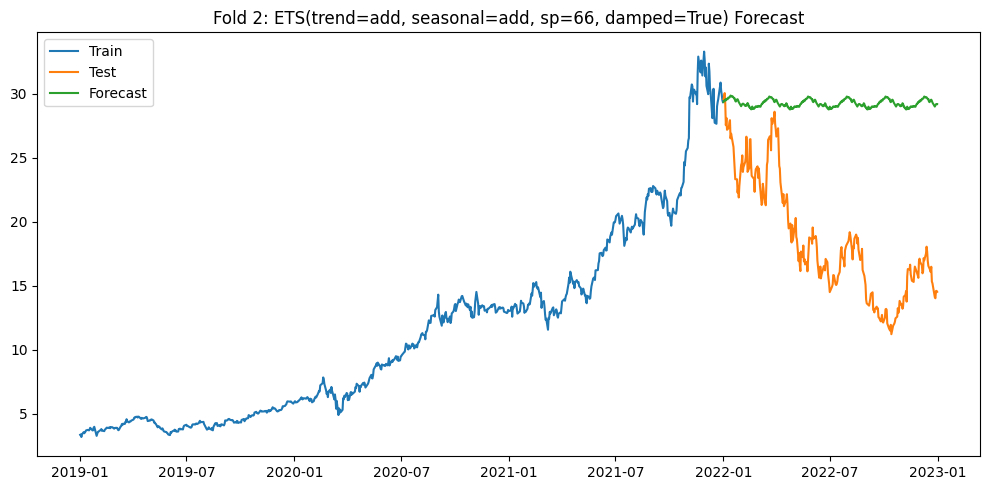


Fold 3 - Train: 2020-01-01 to 2022-12-31 | Test: 2023-01-01 to 2023-12-31
Best ETS config: trend=add, seasonal=add, sp=66, damped=False, RMSE=22.8222
Fold 3 Metrics:
  RMSE: 22.8222
  MAE:  20.4780
  MAPE: 0.5147
  R2:   -3.4402


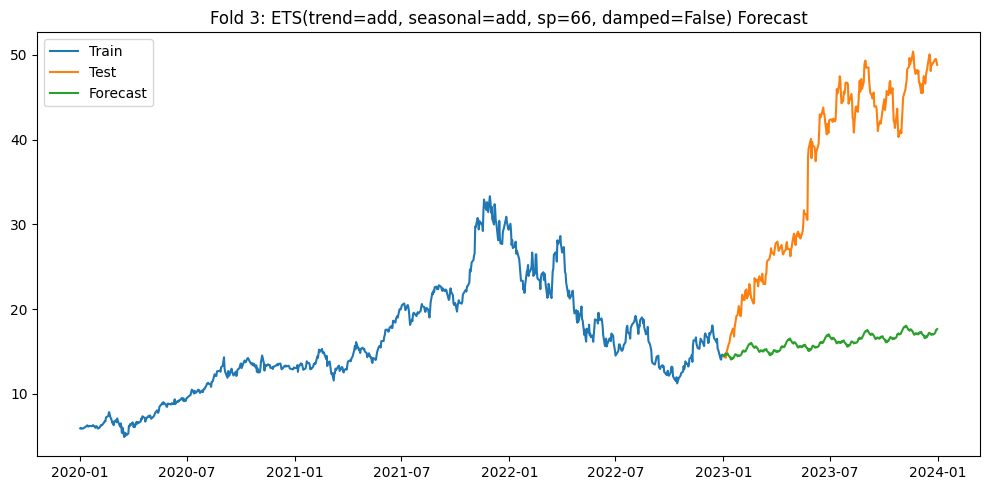

In [ ]:
# Load and preprocess data
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2018-01-01', '2020-12-31', '2021-01-01', '2021-12-31'),
    ('2019-01-01', '2021-12-31', '2022-01-01', '2022-12-31'),
    ('2020-01-01', '2022-12-31', '2023-01-01', '2023-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparam: add add 66 false

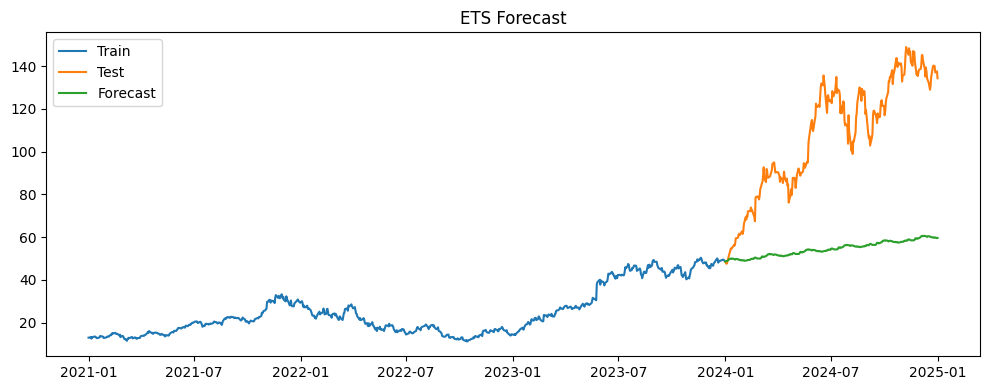

RMSE: 58.32, MAE: 53.22, MAPE: 0.46, R2: -3.70


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2021-01-01':'2023-12-31']['Close']
test = df.loc['2024-01-01':'2024-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# **SPY:**

# Period 1:


Fold 1 - Train: 2012-01-01 to 2014-12-31 | Test: 2015-01-01 to 2015-12-31
Best ETS config: trend=add, seasonal=mul, sp=22, damped=True, RMSE=4.5018
Fold 1 Metrics:
  RMSE: 4.5018
  MAE:  3.4387
  MAPE: 0.0201
  R2:   -0.0324


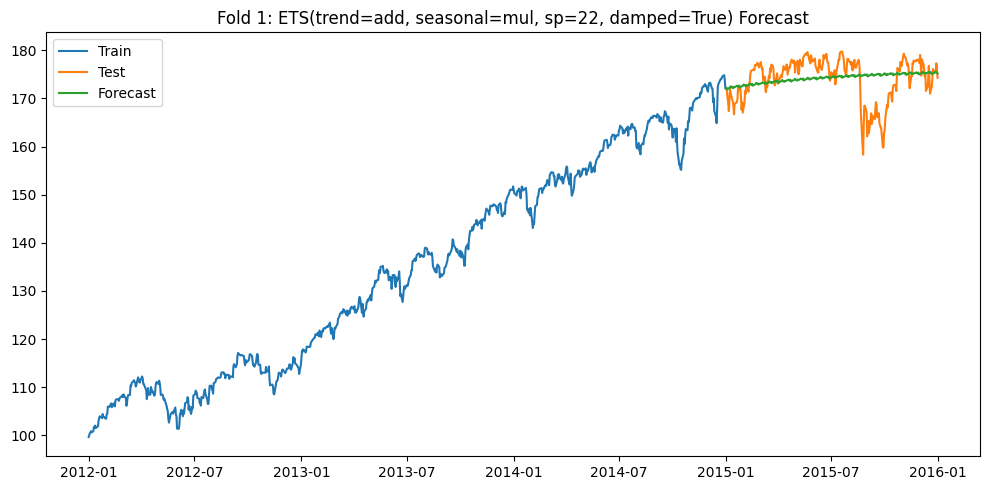


Fold 2 - Train: 2013-01-01 to 2015-12-31 | Test: 2016-01-01 to 2016-12-31
Best ETS config: trend=mul, seasonal=mul, sp=5, damped=False, RMSE=6.1832
Fold 2 Metrics:
  RMSE: 6.1832
  MAE:  4.5186
  MAPE: 0.0262
  R2:   0.5978


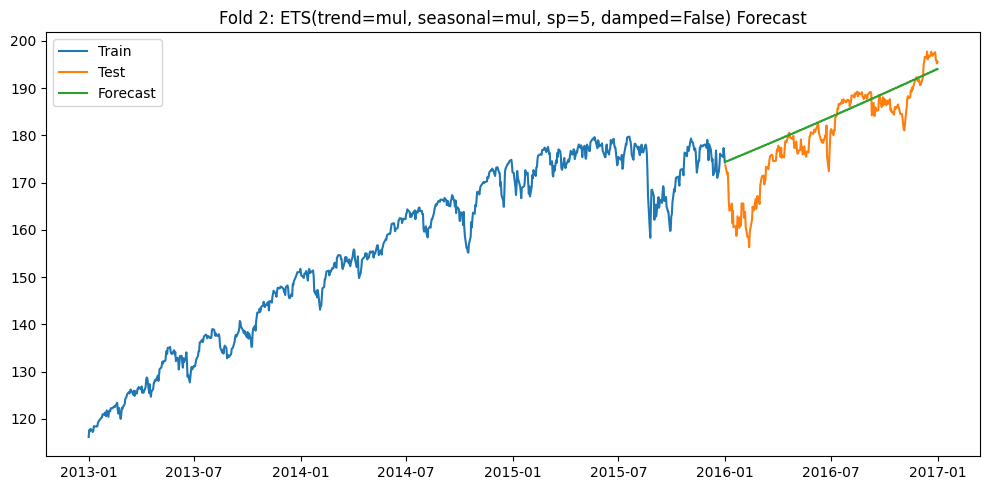


Fold 3 - Train: 2014-01-01 to 2016-12-31 | Test: 2017-01-01 to 2017-12-31
Best ETS config: trend=mul, seasonal=add, sp=66, damped=False, RMSE=12.7015
Fold 3 Metrics:
  RMSE: 12.7015
  MAE:  11.0656
  MAPE: 0.0501
  R2:   -0.3534


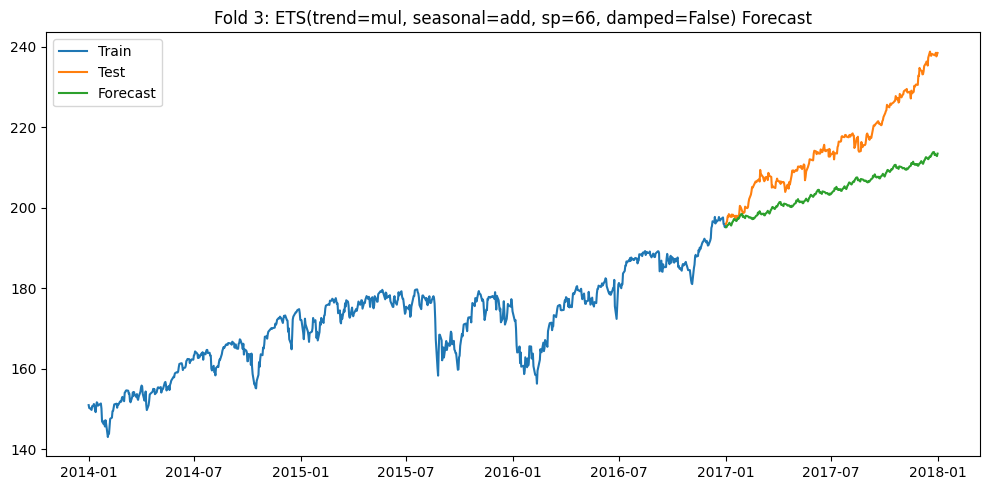

In [ ]:
# Load and preprocess data
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2012-01-01', '2014-12-31', '2015-01-01', '2015-12-31'),
    ('2013-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
    ('2014-01-01', '2016-12-31', '2017-01-01', '2017-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: mul, add, 66, false.

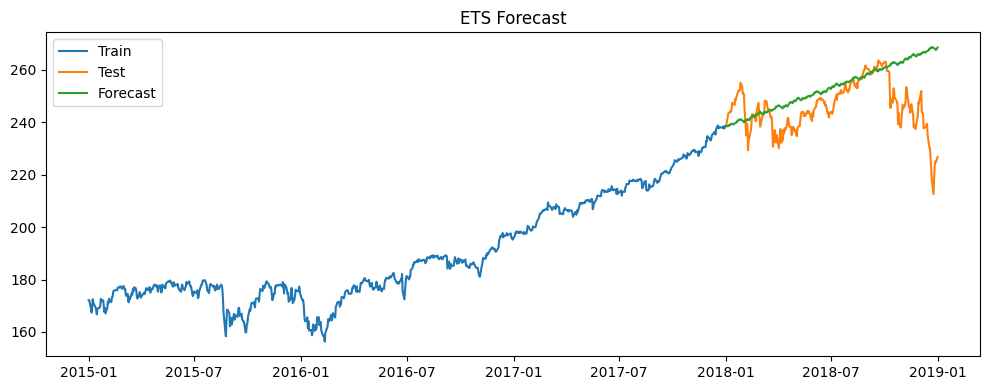

RMSE: 14.25, MAE: 9.66, MAPE: 0.04, R2: -1.36


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('SPY.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2015-01-01':'2017-12-31']['Close']
test = df.loc['2018-01-01':'2018-12-31']['Close']

model = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


## Period 2:


Fold 1 - Train: 2015-01-01 to 2017-12-31 | Test: 2018-01-01 to 2018-12-31
Best ETS config: trend=mul, seasonal=add, sp=5, damped=True, RMSE=9.1772
Fold 1 Metrics:
  RMSE: 9.1772
  MAE:  7.0729
  MAPE: 0.0291
  R2:   0.0226


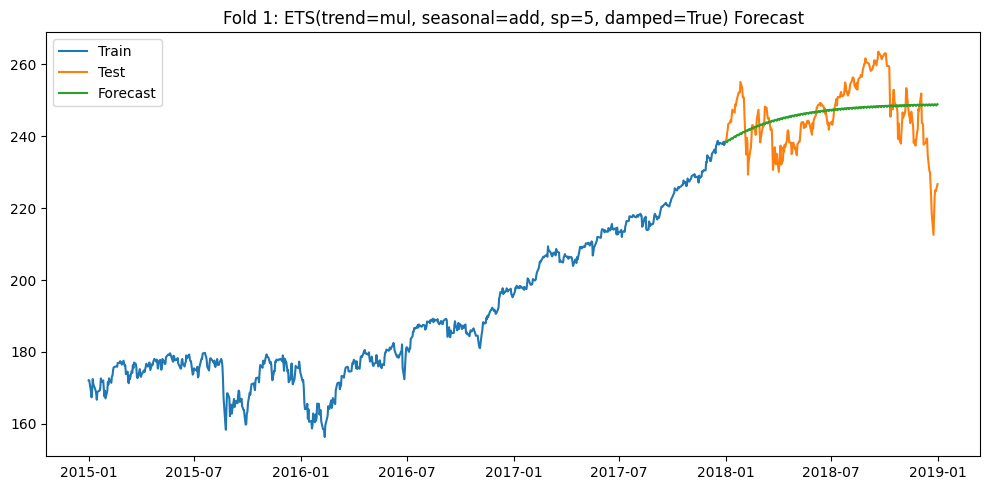


Fold 2 - Train: 2016-01-01 to 2018-12-31 | Test: 2019-01-01 to 2019-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=30.6645
Fold 2 Metrics:
  RMSE: 30.6645
  MAE:  28.7773
  MAPE: 0.1063
  R2:   -3.0425


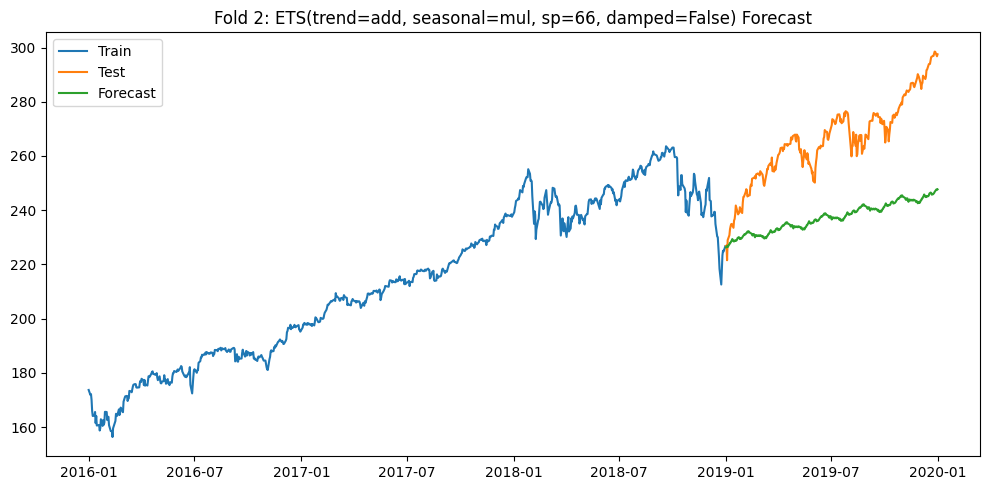


Fold 3 - Train: 2017-01-01 to 2019-12-31 | Test: 2020-01-01 to 2020-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=28.4148
Fold 3 Metrics:
  RMSE: 28.4148
  MAE:  20.4819
  MAPE: 0.0758
  R2:   0.1350


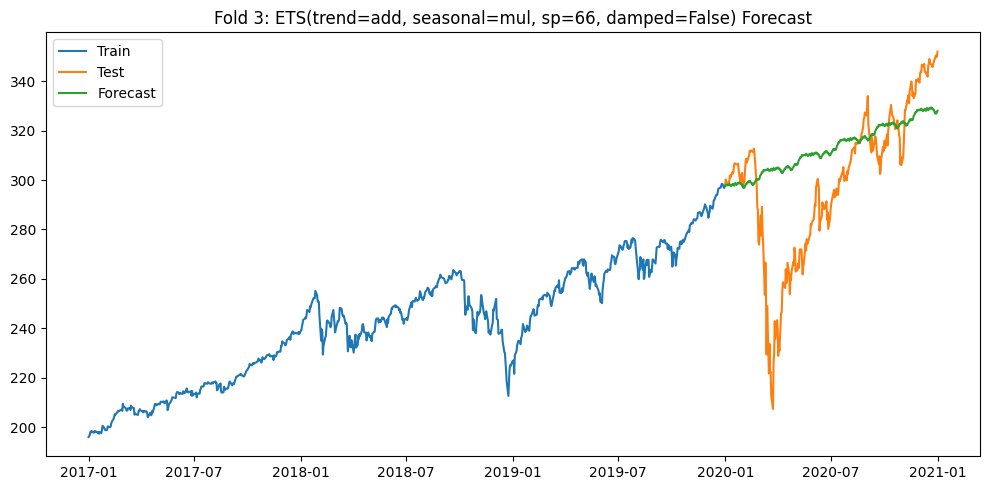

In [ ]:
# Load and preprocess data
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),
    ('2016-01-01', '2018-12-31', '2019-01-01', '2019-12-31'),
    ('2017-01-01', '2019-12-31', '2020-01-01', '2020-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparams: add mul 66 false

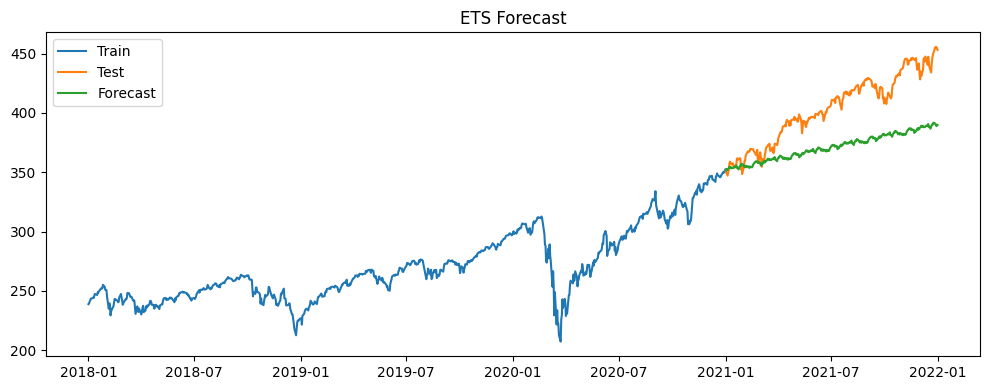

RMSE: 37.06, MAE: 32.47, MAPE: 0.08, R2: -0.66


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('SPY.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2018-01-01':'2020-12-31']['Close']
test = df.loc['2021-01-01':'2021-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# Period 3:


Fold 1 - Train: 2018-01-01 to 2020-12-31 | Test: 2021-01-01 to 2021-12-31
Best ETS config: trend=mul, seasonal=add, sp=22, damped=True, RMSE=20.8900
Fold 1 Metrics:
  RMSE: 20.8900
  MAE:  16.2066
  MAPE: 0.0387
  R2:   0.4719


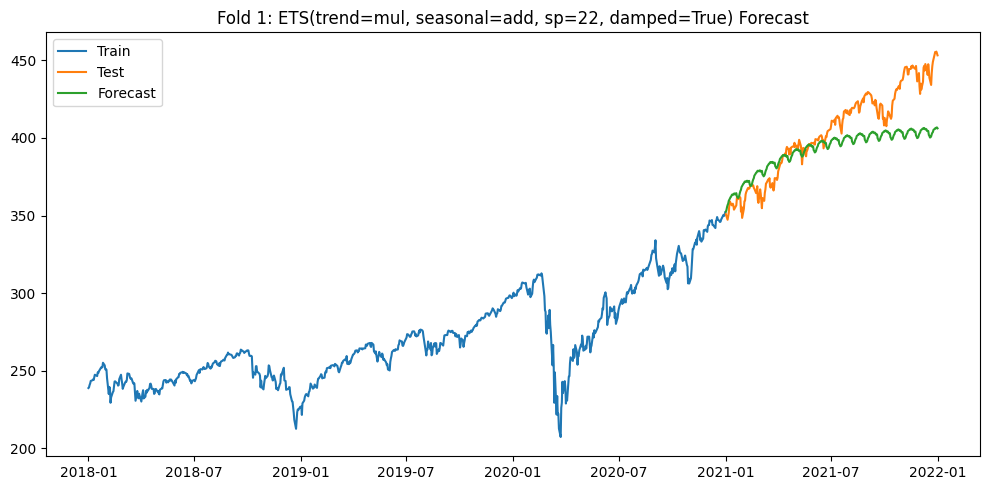


Fold 2 - Train: 2019-01-01 to 2021-12-31 | Test: 2022-01-01 to 2022-12-31
Best ETS config: trend=None, seasonal=mul, sp=5, damped=False, RMSE=65.9855
Fold 2 Metrics:
  RMSE: 65.9855
  MAE:  60.5019
  MAPE: 0.1593
  R2:   -5.2265


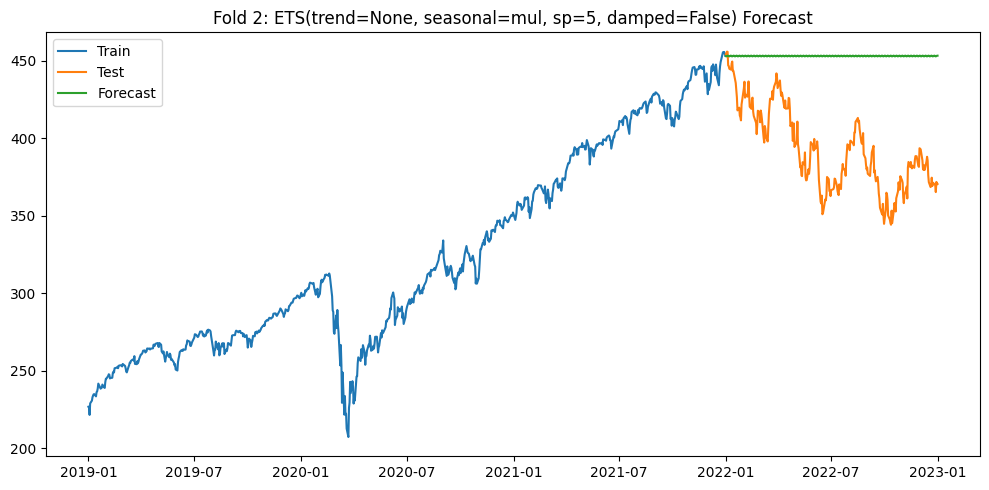


Fold 3 - Train: 2020-01-01 to 2022-12-31 | Test: 2023-01-01 to 2023-12-31
Best ETS config: trend=add, seasonal=mul, sp=66, damped=False, RMSE=38.0407
Fold 3 Metrics:
  RMSE: 38.0407
  MAE:  33.4005
  MAPE: 0.0778
  R2:   -1.4737


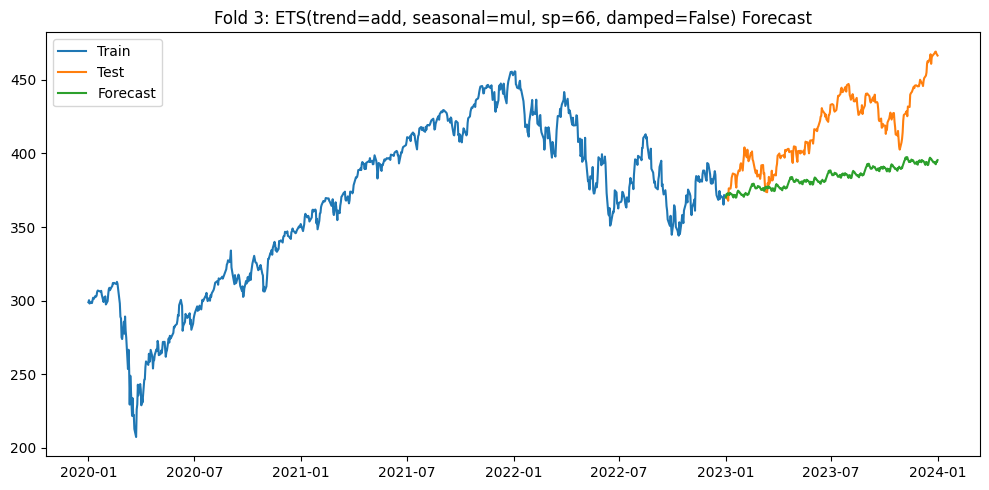

In [ ]:
# Load and preprocess data
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

# Define folds
folds = [
    ('2018-01-01', '2020-12-31', '2021-01-01', '2021-12-31'),
    ('2019-01-01', '2021-12-31', '2022-01-01', '2022-12-31'),
    ('2020-01-01', '2022-12-31', '2023-01-01', '2023-12-31')
]

# Define hyperparameters
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [5, 22, 66]  # weekly & monthly cycles
damped_options = [True, False]
ets_params = list(product(trend_options, seasonal_options, seasonal_periods, damped_options))


# Helper function to evaluate ETS
def evaluate_ets(train, test, trend, seasonal, sp, damped):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method='estimated'
        )
        results = model.fit()
        forecast = results.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return ((trend, seasonal, sp, damped), rmse, results)
    except:
        return ((trend, seasonal, sp, damped), np.inf, None)


# Run folds
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\nFold {i} - Train: {train_start} to {train_end} | Test: {test_start} to {test_end}")
    train = df.loc[train_start:train_end]['Close']
    test = df.loc[test_start:test_end]['Close']

    # Grid Search ETS
    ets_results = Parallel(n_jobs=-1)(
        delayed(evaluate_ets)(train, test, trend, seasonal, sp, damped)
        for (trend, seasonal, sp, damped) in ets_params if not (seasonal is None and sp)
    )
    best_config = min(ets_results, key=lambda x: x[1])
    (best_trend, best_seasonal, best_sp, best_damped), best_rmse, best_model = best_config

    print(f"Best ETS config: trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}, RMSE={best_rmse:.4f}")

    # Forecast using best model
    forecast = best_model.forecast(len(test))

    # Metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)

    print(f"Fold {i} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  R2:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f'Fold {i}: ETS(trend={best_trend}, seasonal={best_seasonal}, sp={best_sp}, damped={best_damped}) Forecast')
    plt.legend()
    plt.tight_layout()
    plt.show()

    del best_model, forecast
    gc.collect()


chosen hyperparam: add mul 66 false

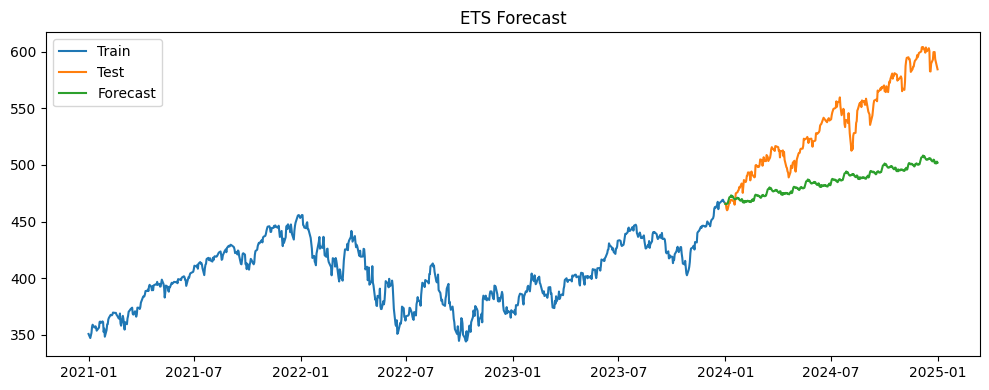

RMSE: 57.29, MAE: 50.49, MAPE: 0.09, R2: -1.24


In [ ]:
# Read CSV skipping the first two metadata rows
df = pd.read_csv('SPY.csv', skiprows=3, header=None)

# Set proper column names
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

# Ensure daily frequency and interpolate missing Close values
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)

train = df.loc['2021-01-01':'2023-12-31']['Close']
test = df.loc['2024-01-01':'2024-12-31']['Close']

model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
results = model.fit()
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
# Removed confidence intervals (not available here)
plt.legend()
plt.title('ETS Forecast')
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}')


# Weekly:

# AAPL:


100%|██████████| 73/73 [00:25<00:00,  2.81it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 3.2013
  MAE:  2.2733
  MAPE: 0.0163
  R2:   0.9511


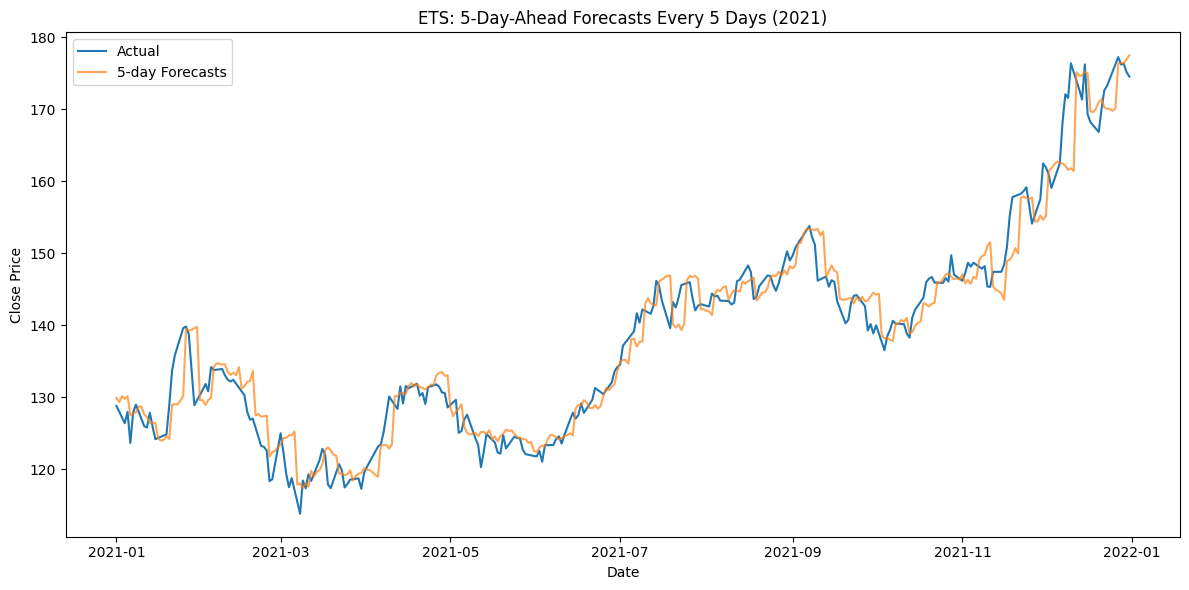

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 74/74 [00:11<00:00,  6.26it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 4.1076
  MAE:  2.9575
  MAPE: 0.0143
  R2:   0.9747


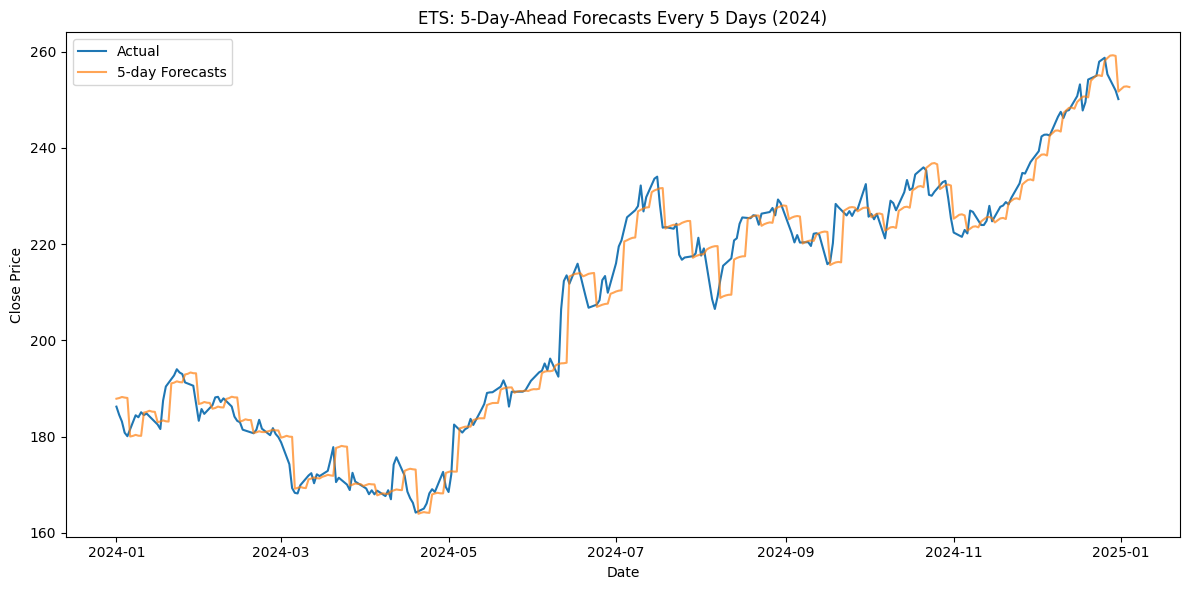

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 73/73 [01:07<00:00,  1.09it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 1.1290
  MAE:  0.7494
  MAPE: 0.0169
  R2:   0.9486


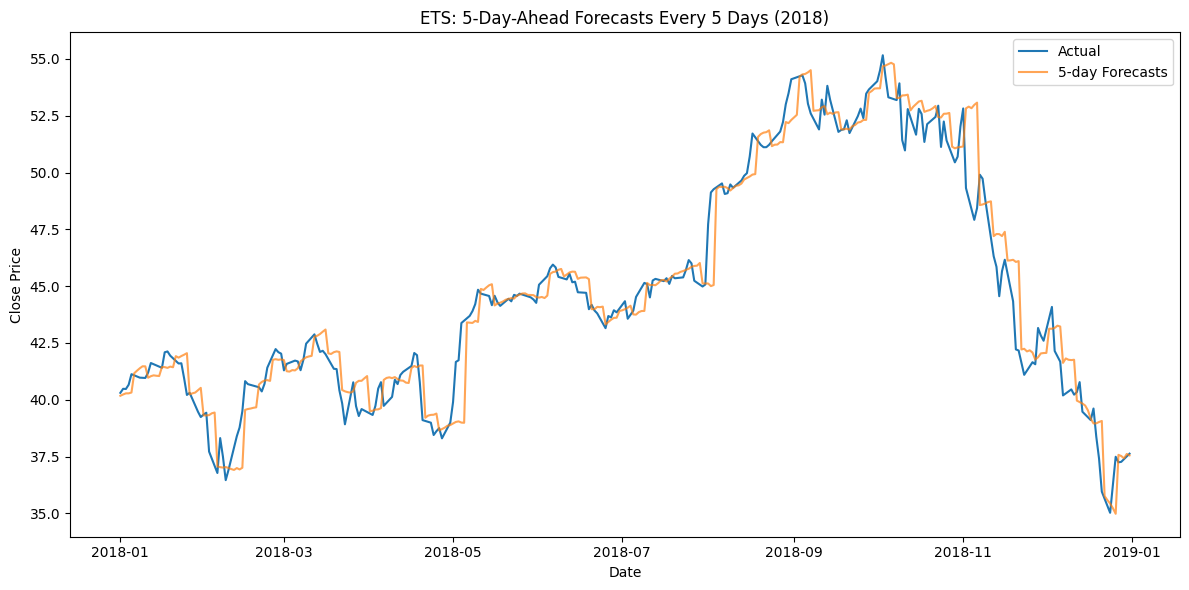

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='add', seasonal_periods=22, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# JPM:


100%|██████████| 73/73 [00:54<00:00,  1.33it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 2.9295
  MAE:  2.1747
  MAPE: 0.0155
  R2:   0.9057


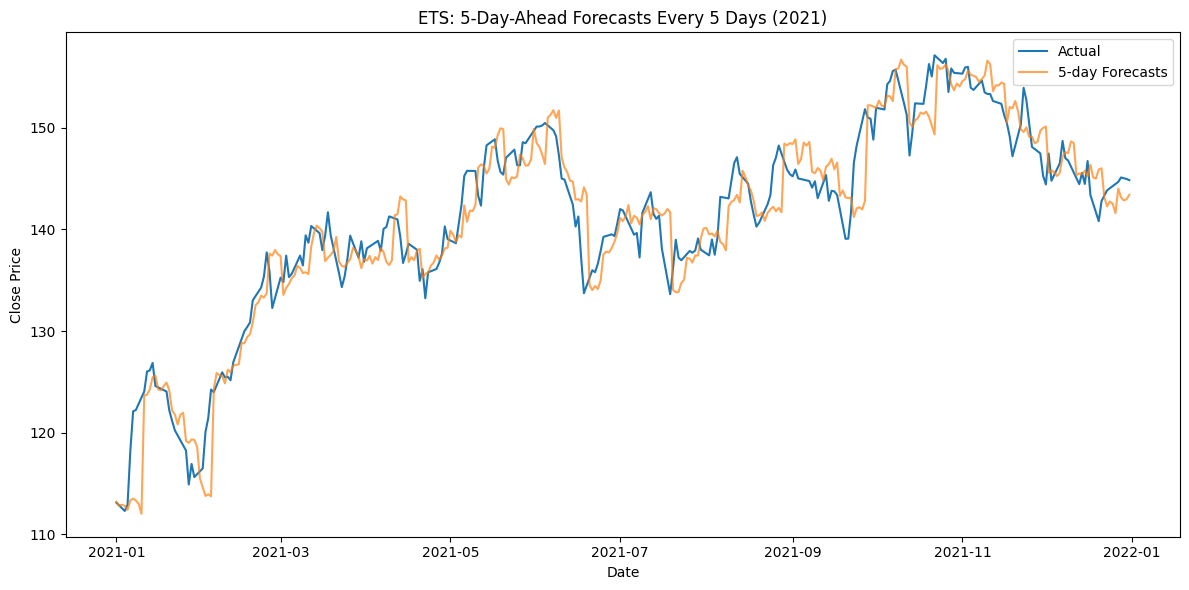

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 74/74 [02:09<00:00,  1.74s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 3.9364
  MAE:  2.5087
  MAPE: 0.0122
  R2:   0.9698


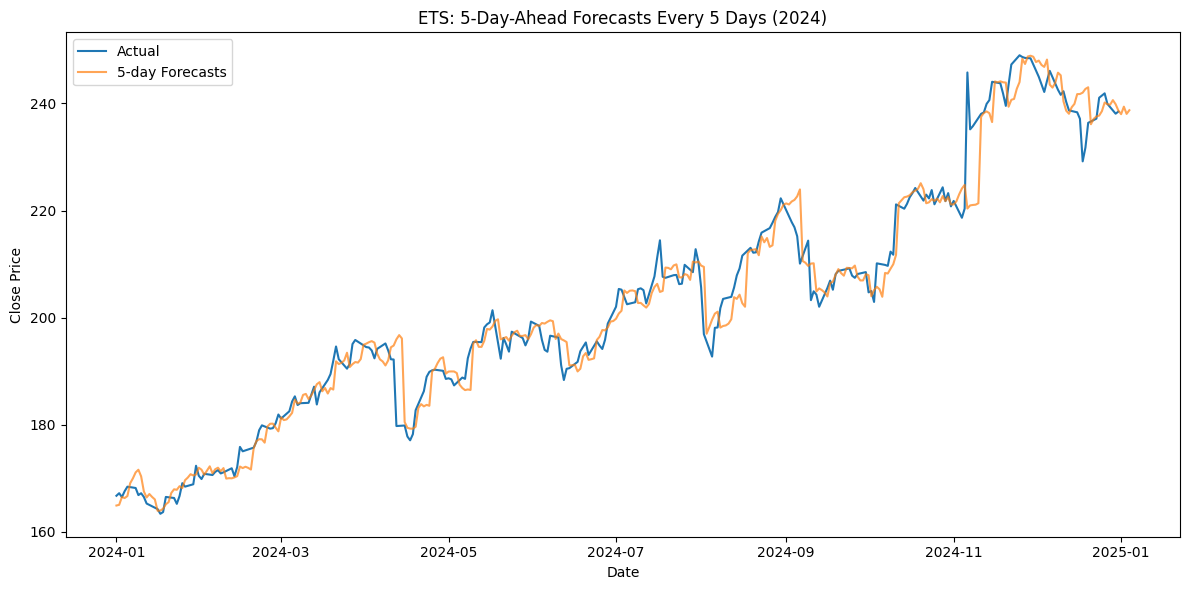

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 73/73 [01:30<00:00,  1.23s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 1.6893
  MAE:  1.2103
  MAPE: 0.0133
  R2:   0.8154


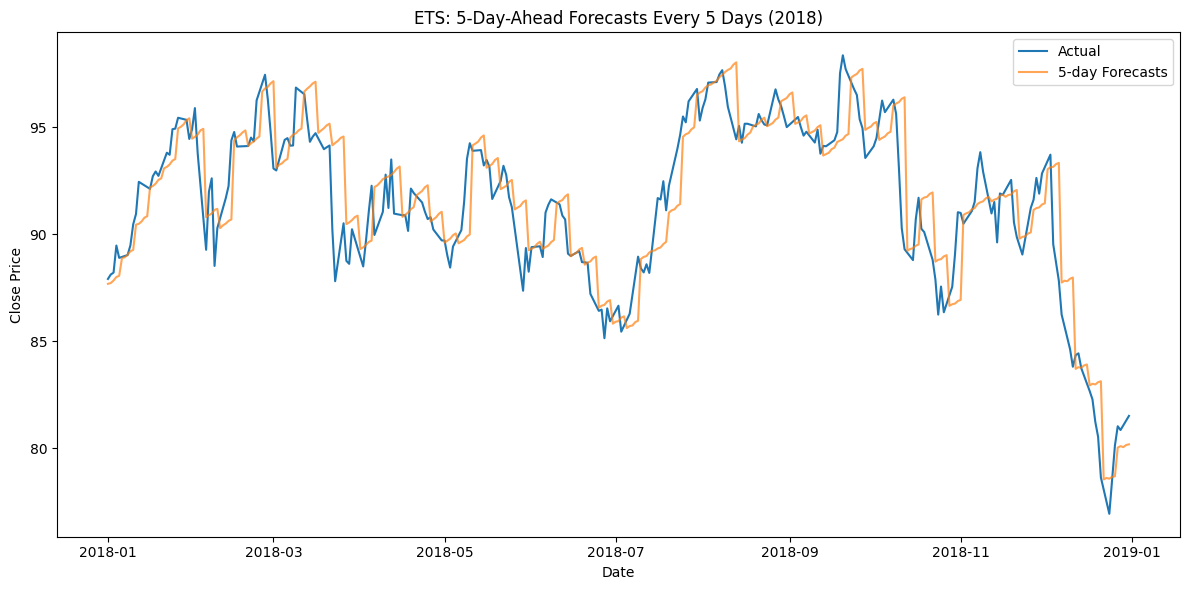

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# NVDA:


100%|██████████| 73/73 [01:09<00:00,  1.04it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.7928
  MAE:  0.5538
  MAPE: 0.0280
  R2:   0.9817


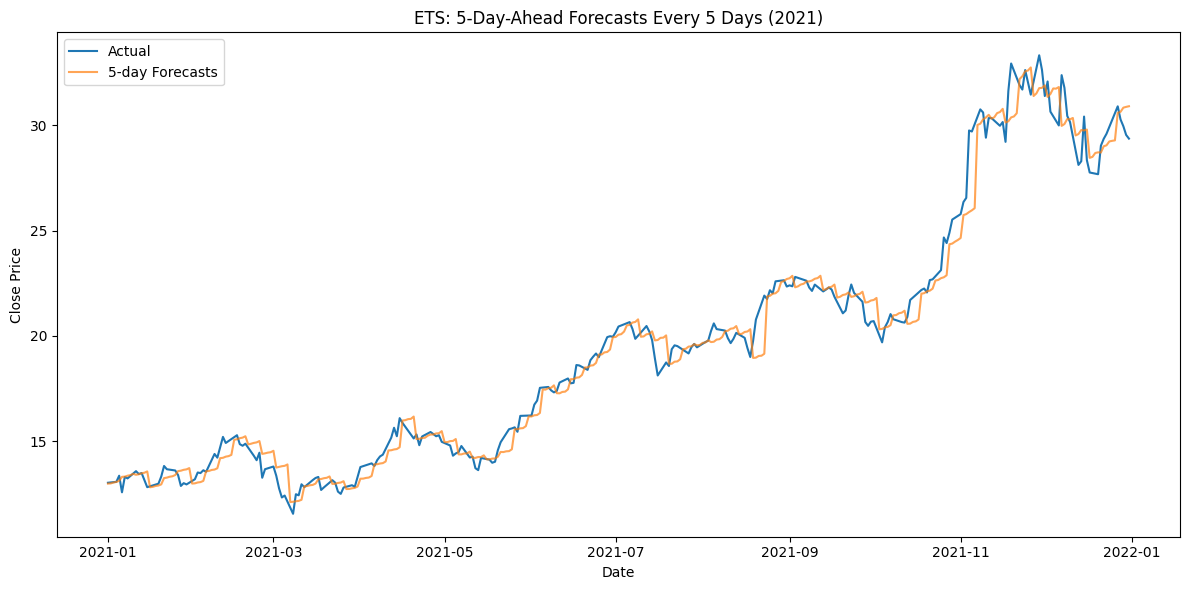

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 74/74 [00:23<00:00,  3.11it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 4.8826
  MAE:  3.5207
  MAPE: 0.0325
  R2:   0.9673


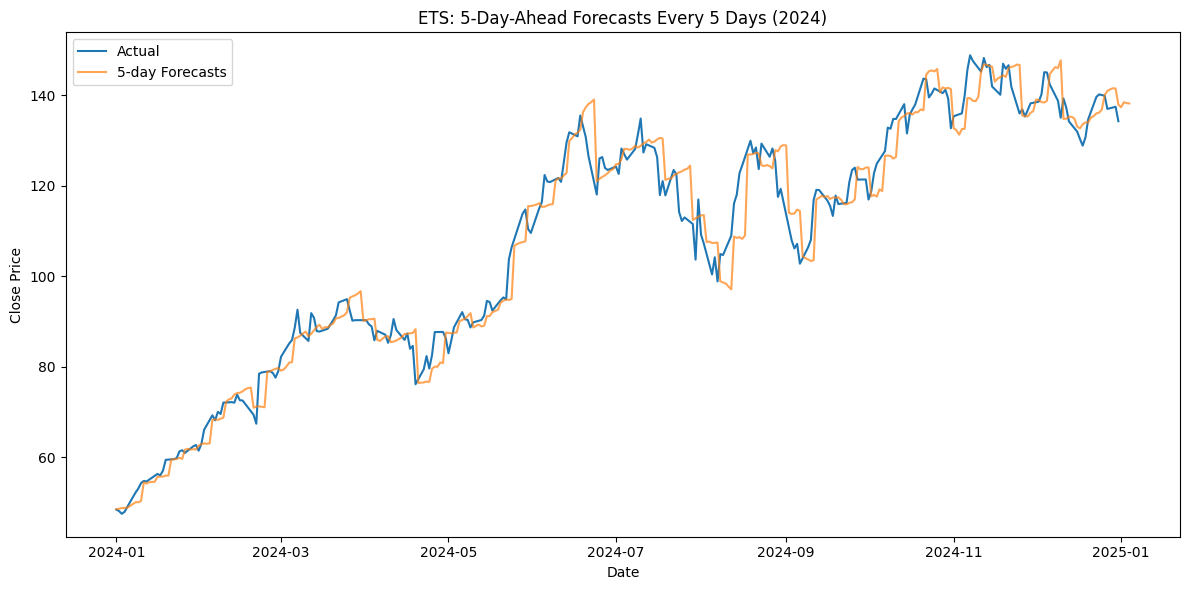

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 73/73 [00:10<00:00,  6.92it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.2187
  MAE:  0.1561
  MAPE: 0.0287
  R2:   0.9445


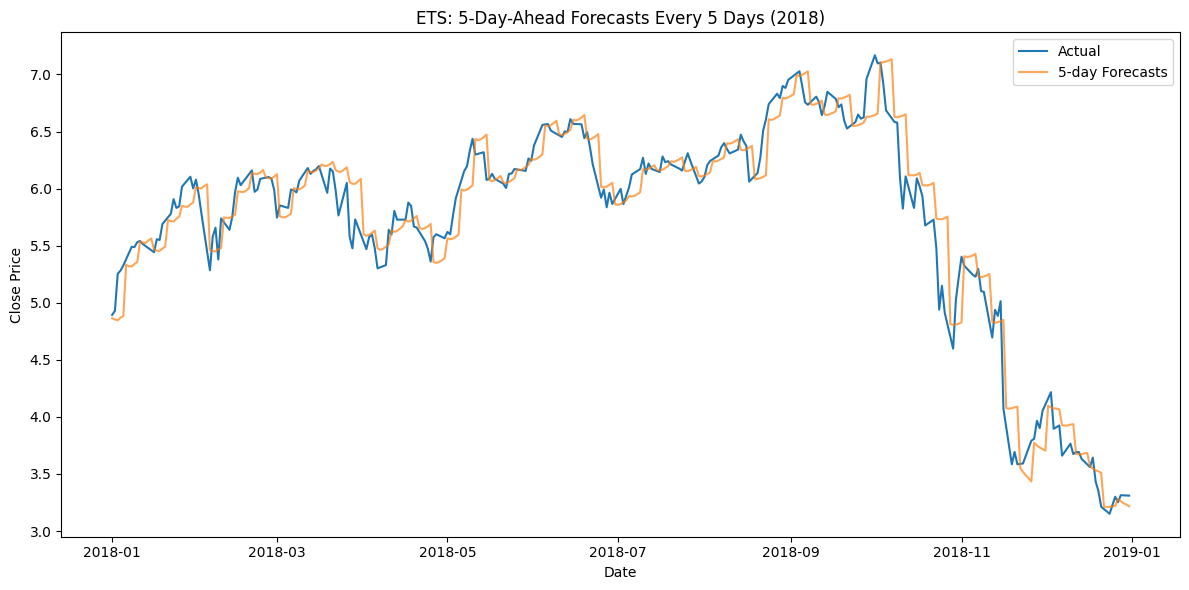

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# SPY:


100%|██████████| 73/73 [00:46<00:00,  1.56it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 4.9671
  MAE:  3.7204
  MAPE: 0.0093
  R2:   0.9701


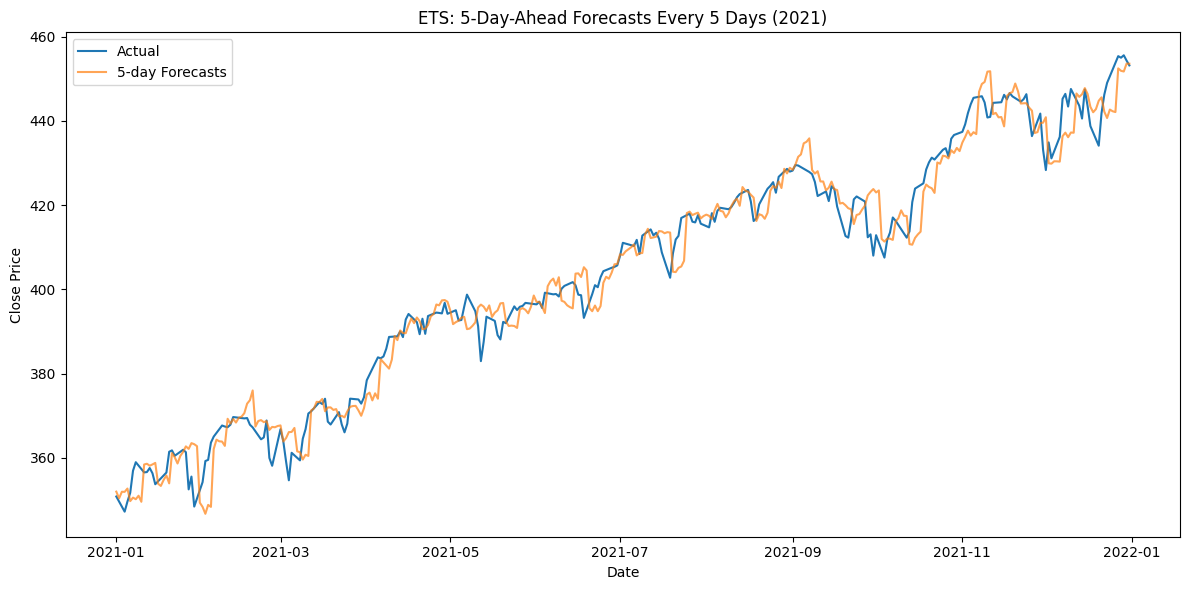

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 74/74 [00:35<00:00,  2.08it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 6.5258
  MAE:  4.5973
  MAPE: 0.0085
  R2:   0.9711


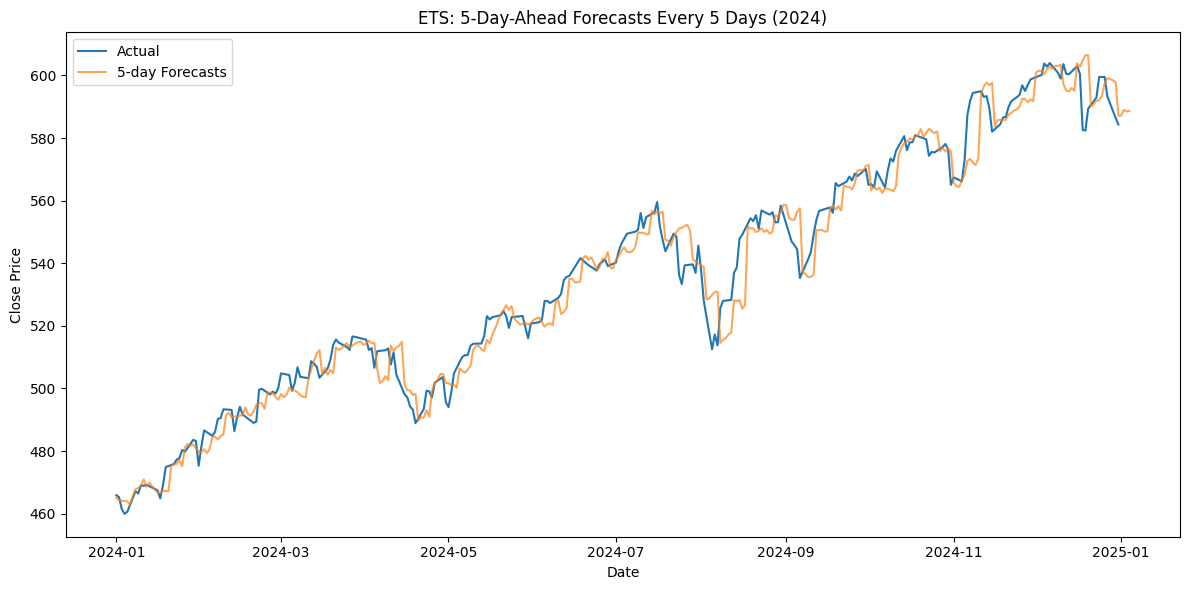

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 73/73 [01:19<00:00,  1.09s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 3.4630
  MAE:  2.4349
  MAPE: 0.0101
  R2:   0.8608


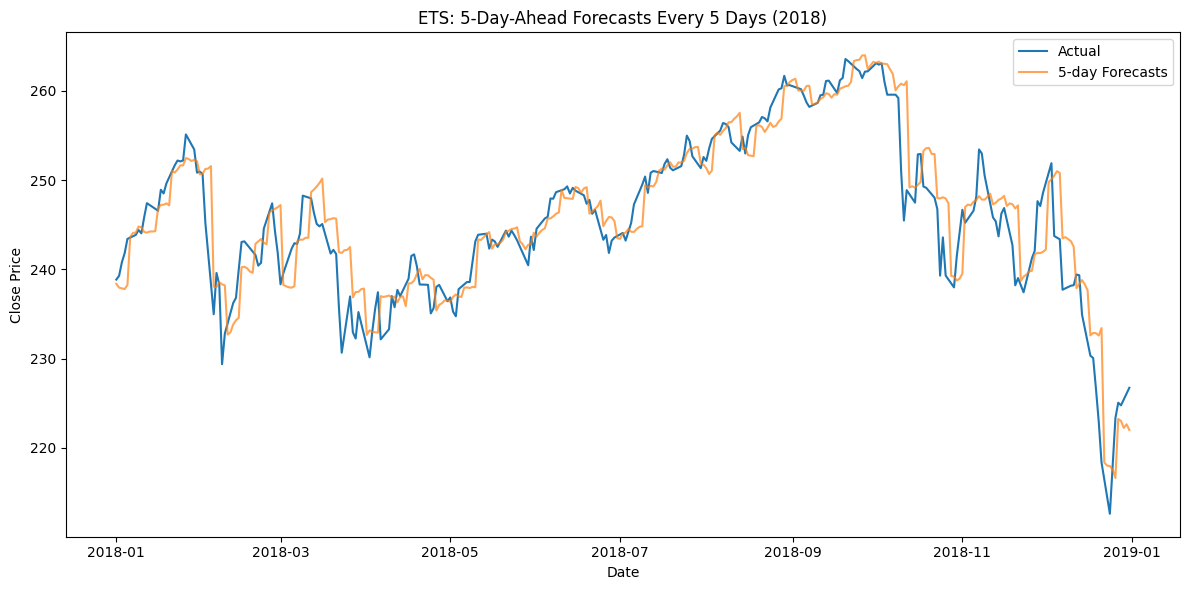

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 5
step_size = 5
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="5-day Forecasts", alpha=0.7)
plt.title("ETS: 5-Day-Ahead Forecasts Every 5 Days (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Daily:

# AAPL:

100%|██████████| 365/365 [06:05<00:00,  1.00s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 1.6955
  MAE:  1.2407
  MAPE: 0.0091
  R2:   0.9863


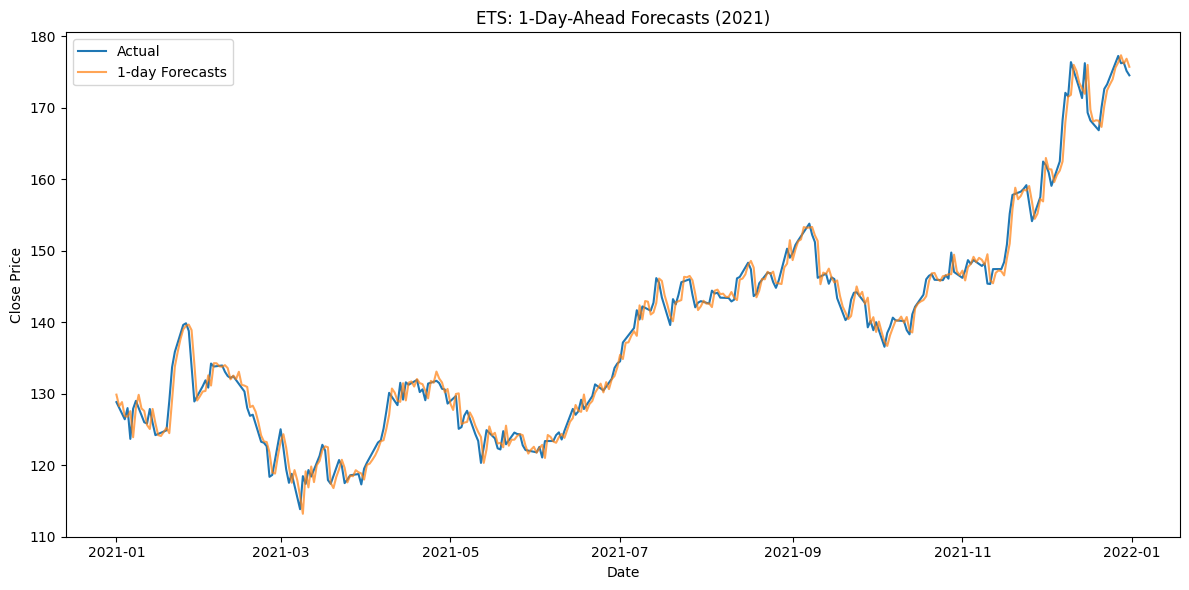

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 366/366 [01:35<00:00,  3.81it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 2.1326
  MAE:  1.4467
  MAPE: 0.0071
  R2:   0.9931


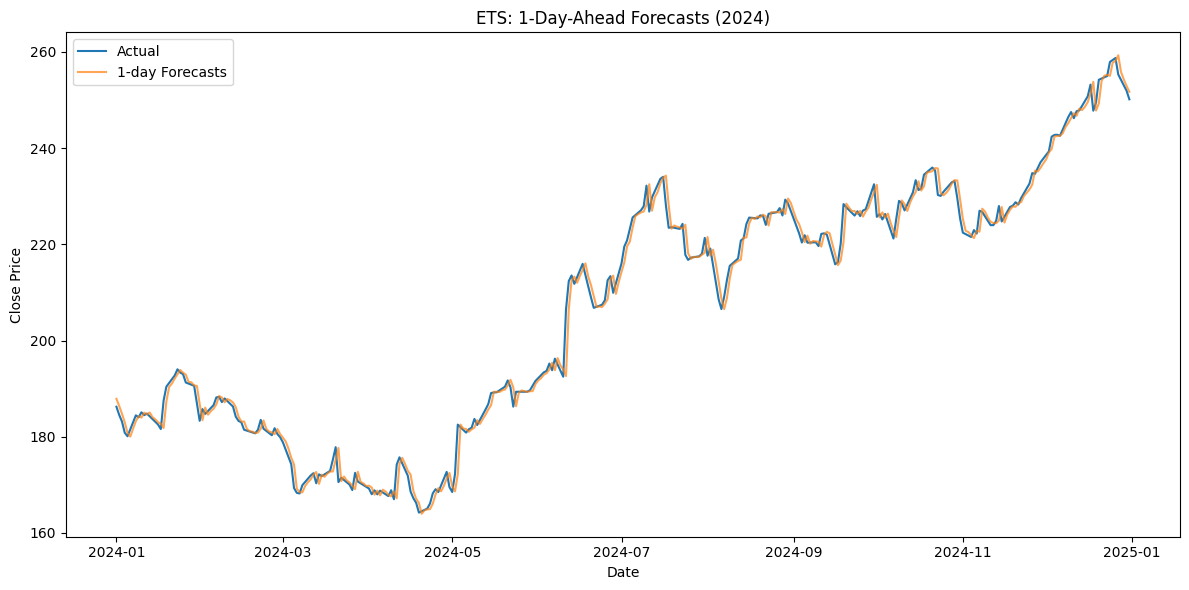

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 365/365 [08:16<00:00,  1.36s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.6167
  MAE:  0.4039
  MAPE: 0.0091
  R2:   0.9847


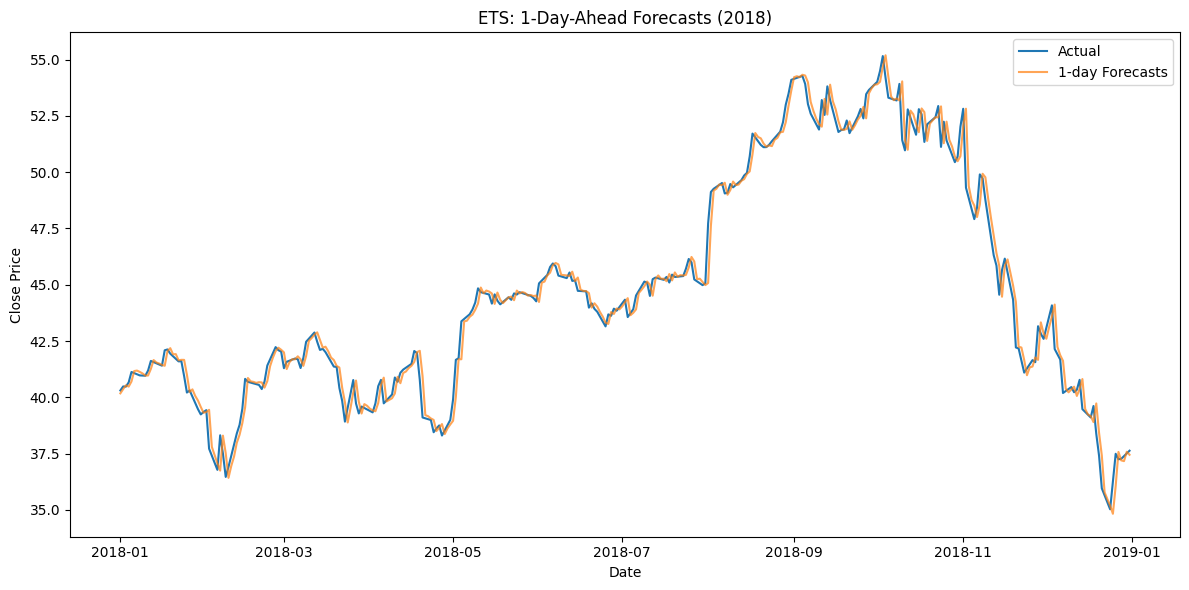

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('AAPL.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='add', seasonal_periods=22, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# JPM:

100%|██████████| 365/365 [03:21<00:00,  1.81it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 1.5391
  MAE:  1.1733
  MAPE: 0.0084
  R2:   0.9740


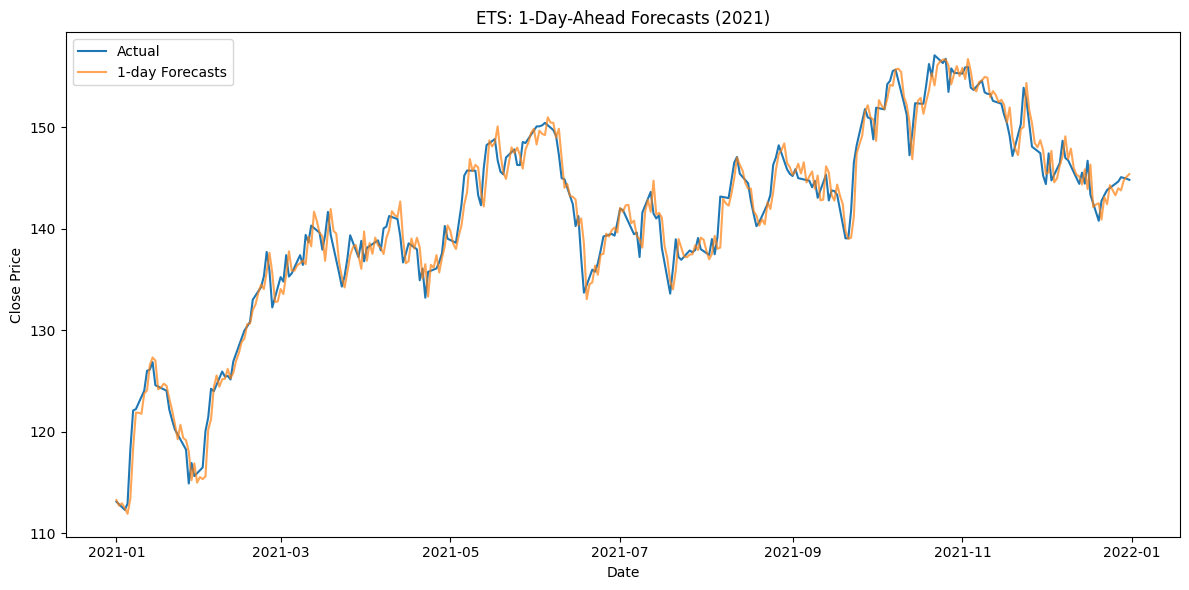

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 366/366 [13:31<00:00,  2.22s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 2.5253
  MAE:  1.4790
  MAPE: 0.0072
  R2:   0.9873


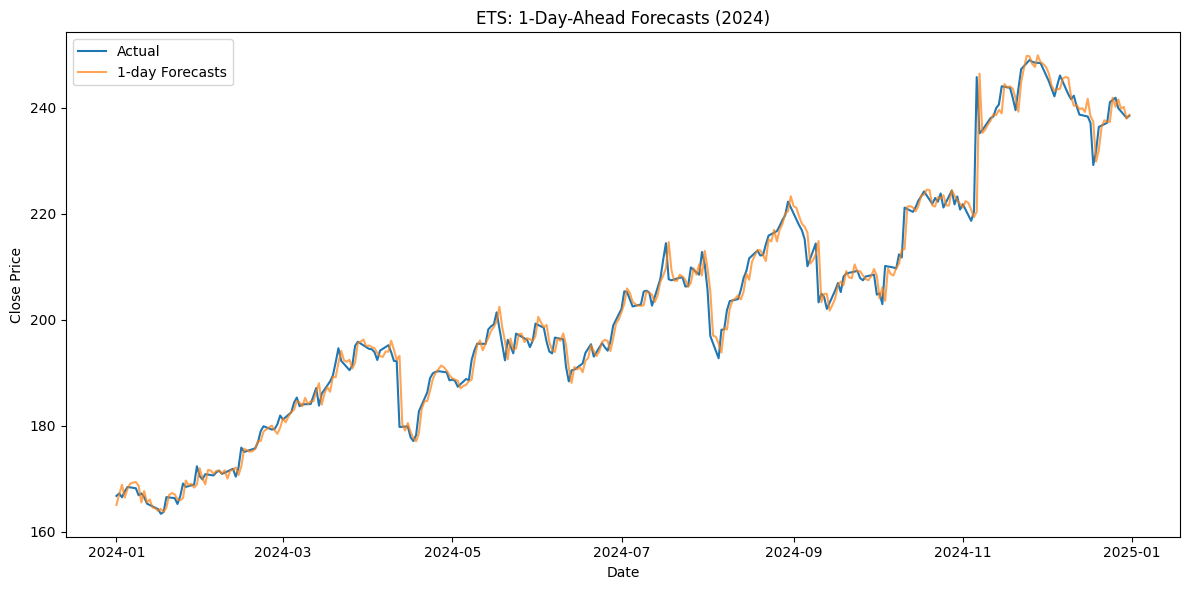

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 365/365 [05:14<00:00,  1.16it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.9384
  MAE:  0.6571
  MAPE: 0.0072
  R2:   0.9431


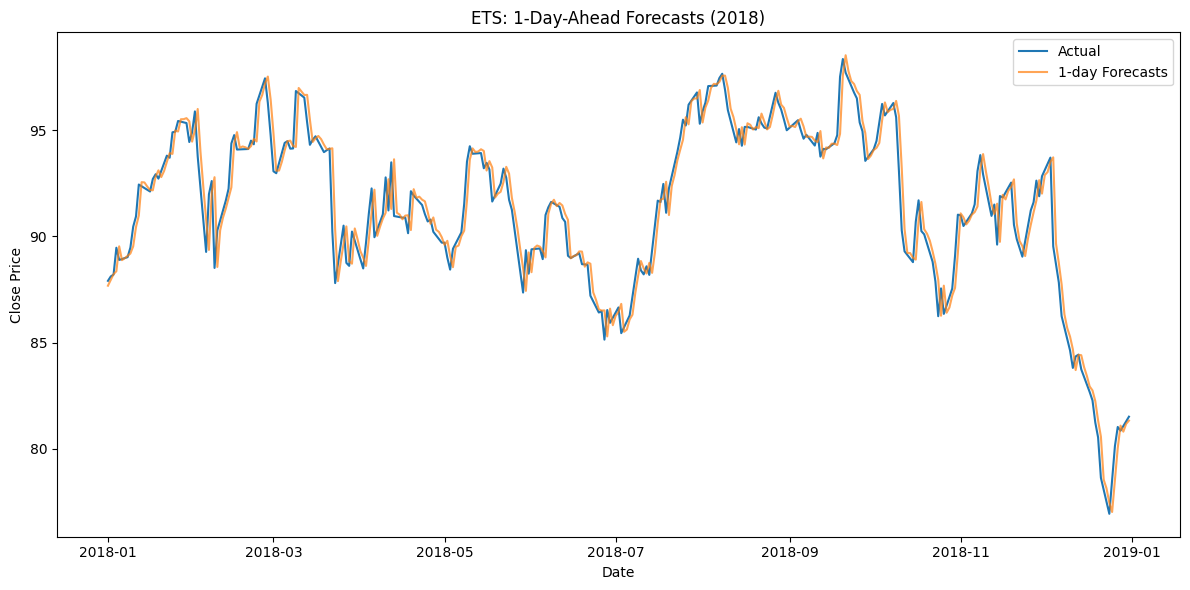

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('JPM.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# NVDA:

100%|██████████| 365/365 [05:19<00:00,  1.14it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.4776
  MAE:  0.2986
  MAPE: 0.0148
  R2:   0.9934


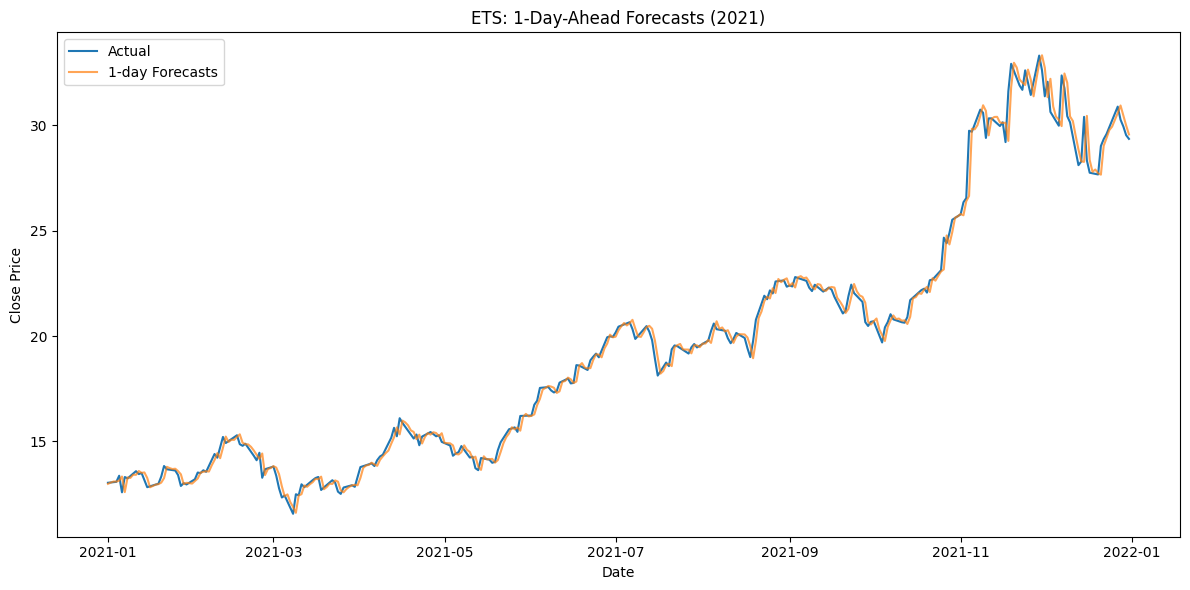

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 366/366 [03:37<00:00,  1.69it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 2.7060
  MAE:  1.8675
  MAPE: 0.0174
  R2:   0.9899


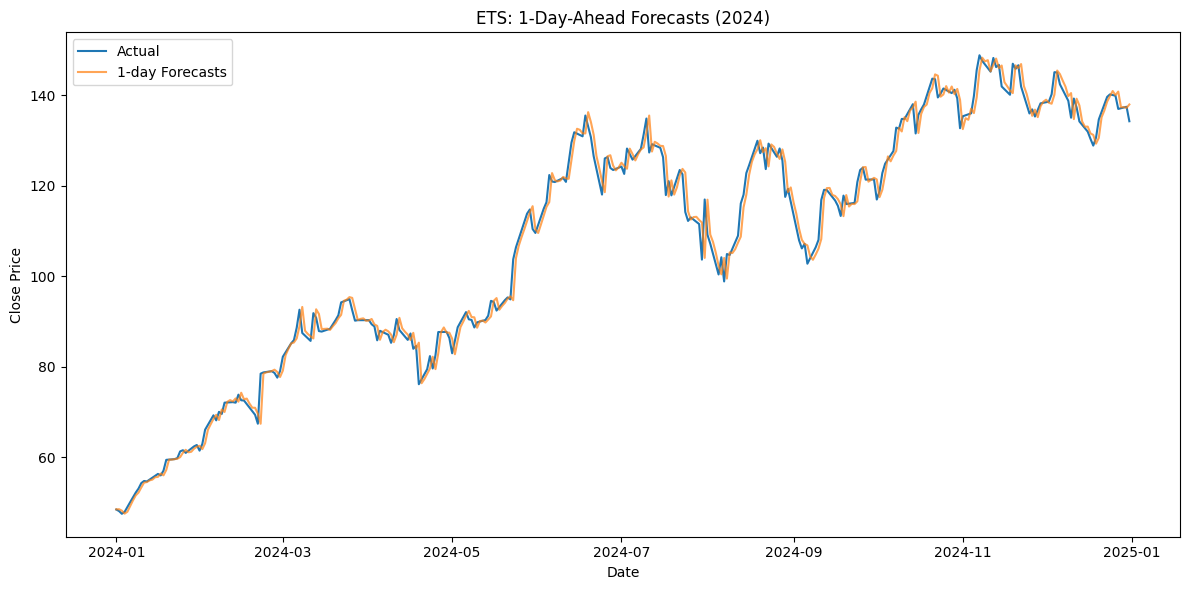

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 365/365 [01:01<00:00,  5.94it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 0.1264
  MAE:  0.0825
  MAPE: 0.0153
  R2:   0.9814


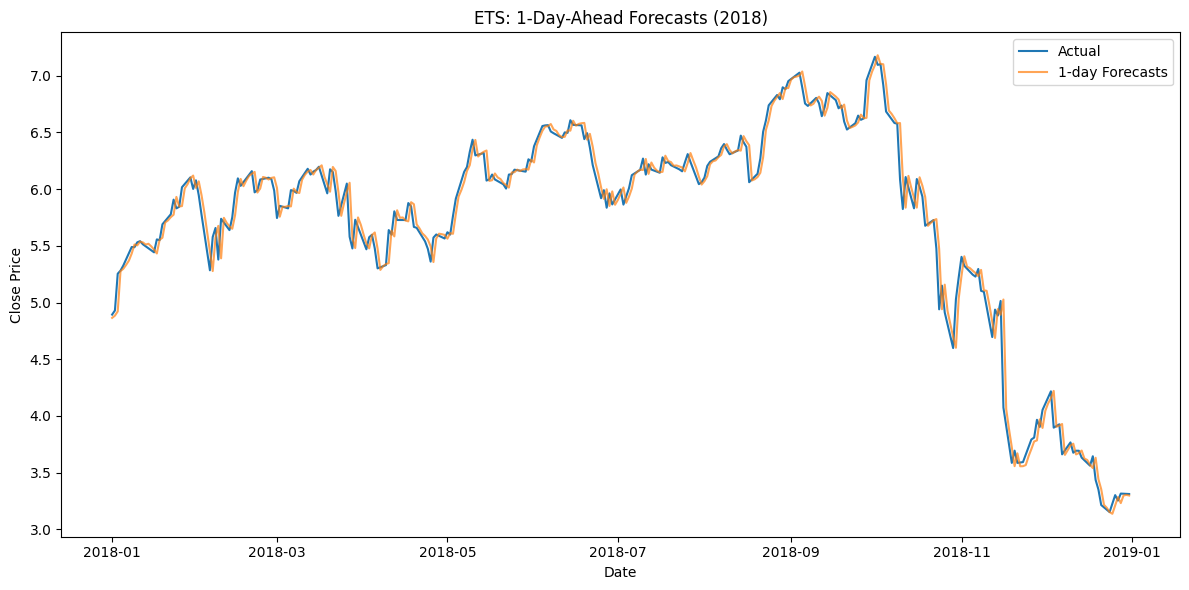

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('NVDA.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# SPY:

100%|██████████| 365/365 [03:28<00:00,  1.75it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 2.7005
  MAE:  2.0369
  MAPE: 0.0051
  R2:   0.9912


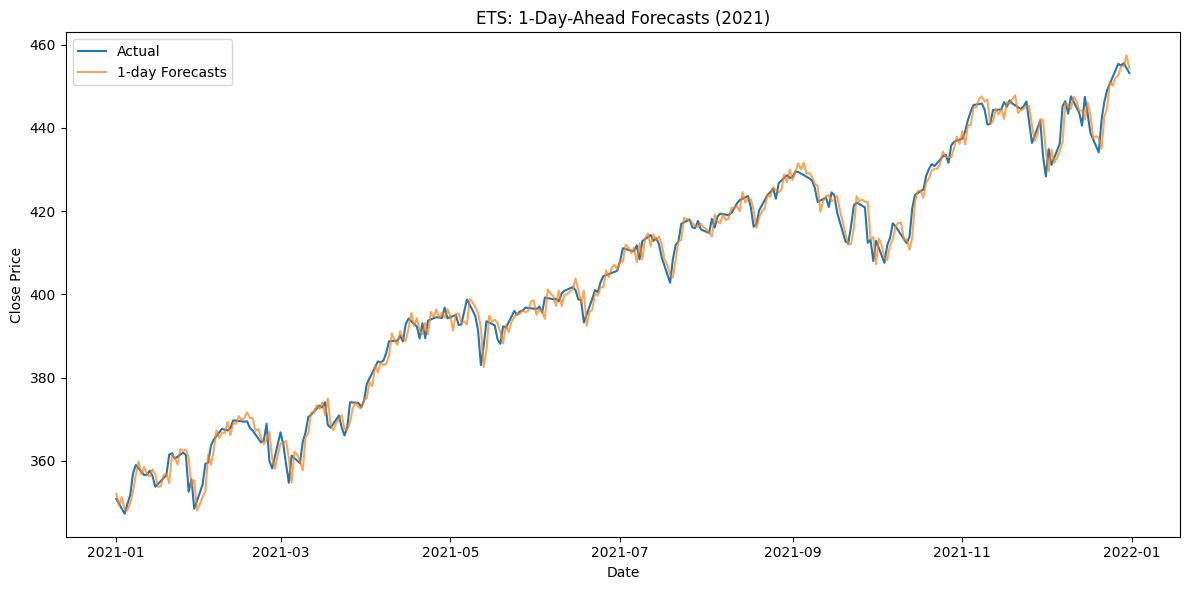

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2021-01-01", "2021-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2021"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2021)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 366/366 [03:44<00:00,  1.63it/s]



Sliding 5-Day Forecast Metrics:
  RMSE: 3.5318
  MAE:  2.4452
  MAPE: 0.0046
  R2:   0.9915


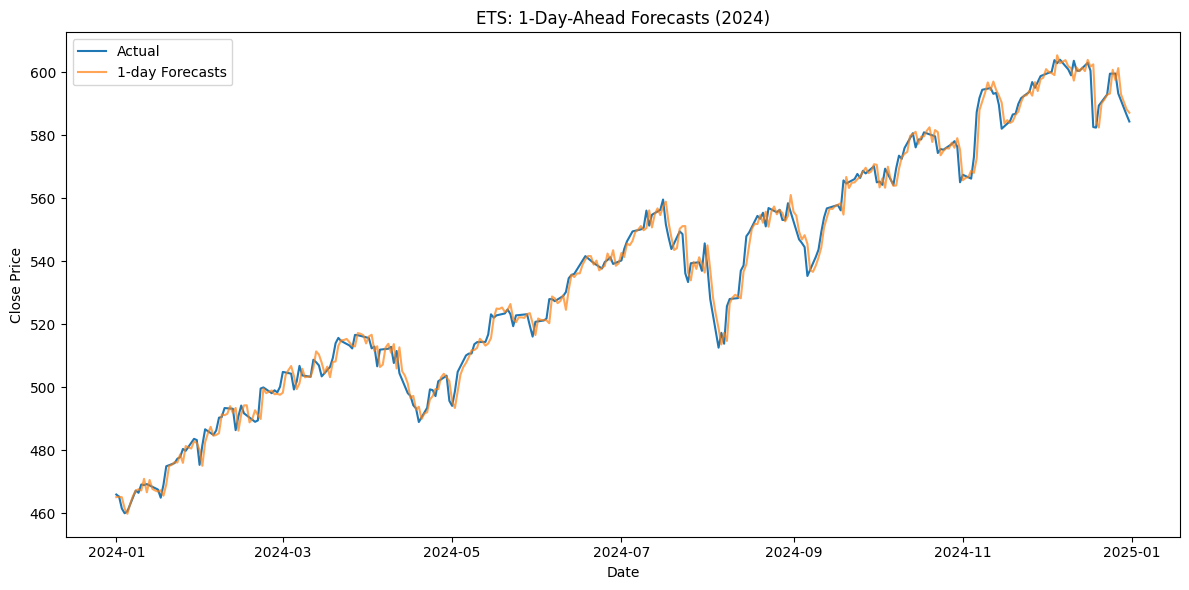

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2024-01-01", "2024-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 365/365 [11:19<00:00,  1.86s/it]



Sliding 5-Day Forecast Metrics:
  RMSE: 1.9614
  MAE:  1.2828
  MAPE: 0.0053
  R2:   0.9555


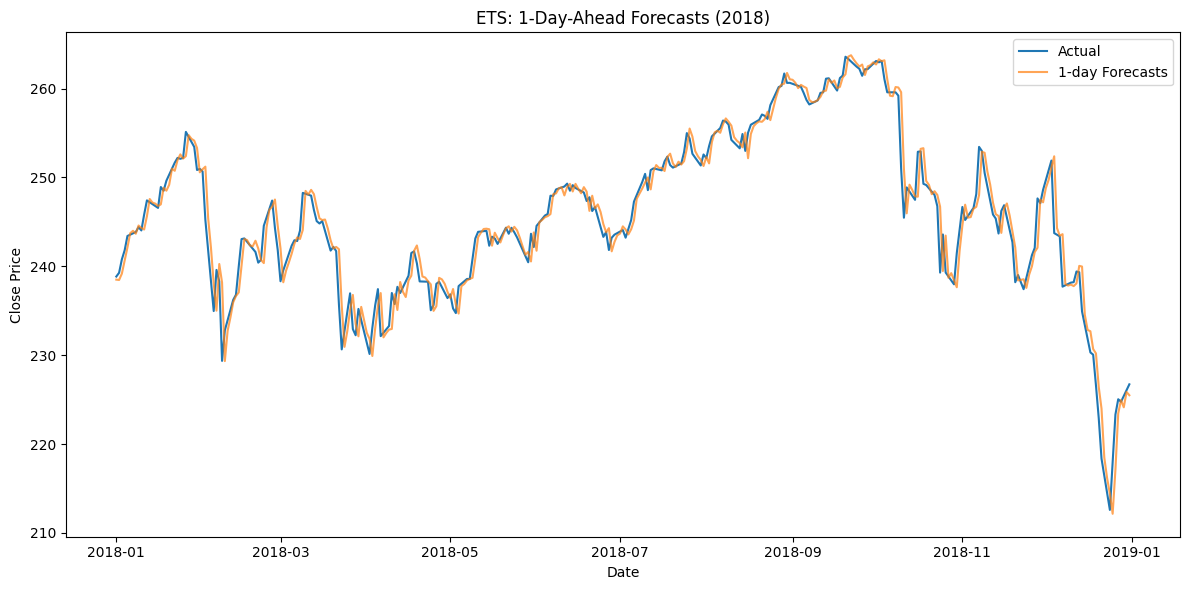

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = pd.date_range("2018-01-01", "2018-12-31", freq=f"{step_size}D")

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_5_days(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='add', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
        preds = forecast
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    for offset, pred_date in enumerate(pd.date_range(forecast_start, periods=forecast_horizon)):
        if pred_date not in series.index:
            continue
        # Ensure the pred_date is within the forecast index to avoid KeyError
        if pred_date in forecast.index:
             results_list.append({
                "Date": pred_date,
                "Actual": series[pred_date],
                "Predicted": preds.loc[pred_date]
            })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_5_days)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 5-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2018"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Fix?



  0%|          | 0/366 [00:00<?, ?it/s]

  1%|          | 4/366 [00:02<03:04,  1.96it/s]

  2%|▏         | 6/366 [00:04<04:23,  1.37it/s]

  2%|▏         | 8/366 [00:07<06:03,  1.02s/it]

  3%|▎         | 10/366 [00:09<06:49,  1.15s/it]

  3%|▎         | 12/366 [00:11<06:30,  1.10s/it]

  4%|▍         | 14/366 [00:13<06:01,  1.03s/it]

  4%|▍         | 16/366 [00:15<06:00,  1.03s/it]

  5%|▍         | 18/366 [00:17<05:53,  1.01s/it]

  5%|▌         | 20/366 [00:19<05:57,  1.03s/it]

  6%|▌         | 22/366 [00:23<07:27,  1.30s/it]

  7%|▋         | 24/366 [00:26<07:12,  1.26s/it]

  7%|▋         | 26/366 [00:28<06:46,  1.19s/it]

  8%|▊         | 28/366 [00:30<06:20,  1.12s/it]

  8%|▊         | 30/366 [00:31<06:03,  1.08s/it]

  9%|▊         | 32/366 [00:34<06:11,  1.11s/it]

  9%|▉         | 34/366 [00:37<06:54,  1.25s/it]

 10%|▉         | 36/366 [00:39<06:15,  1.14s/it]

 10%|█         | 38/366 [00:41<05:53,  1.08s/it]

 11%|█         | 40/366 [00:43<05:38,  1.04s/it]

 11%|█▏   


Sliding 1-Day Forecast Metrics:
  RMSE: 3.5318
  MAE:  2.4452
  MAPE: 0.0046
  R2:   0.9915


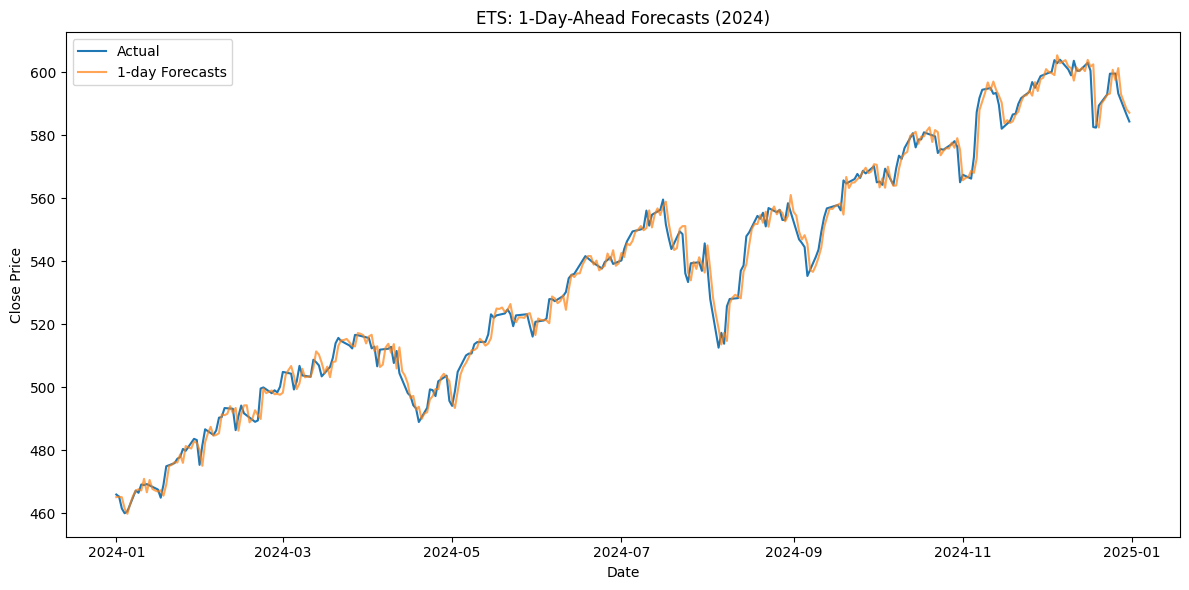

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv('SPY.csv', skiprows=3, header=None)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')
df['Close'].interpolate(method='time', inplace=True)
series = df['Close']

# -------------------------------
# Forecast settings
# -------------------------------
forecast_horizon = 1
step_size = 1
train_window_days = 750

forecast_dates = series["2024"].index

# -------------------------------
# Forecasting function
# -------------------------------
def forecast_next_day(forecast_start):
    train_end = forecast_start - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=train_window_days - 1)

    if train_start < series.index[0]:
        return []

    train_data = series[train_start:train_end]

    try:
        model = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=66, damped_trend=False)
        results = model.fit()
        forecast = results.forecast(steps=forecast_horizon)
    except Exception as e:
        print(f"Error forecasting for date {forecast_start}: {e}")
        return []


    results_list = []
    pred_date = forecast.index[0]
    results_list.append({
        "Date": pred_date,
        "Actual": series[pred_date],
        "Predicted": forecast.iloc[0]
    })
    return results_list

# -------------------------------
# Run forecasts in parallel
# -------------------------------
all_results = Parallel(n_jobs=-1)(
    delayed(forecast_next_day)(day) for day in tqdm(forecast_dates)
)

# Flatten list of lists
forecast_flat = [item for sublist in all_results for item in sublist]

# -------------------------------
# Evaluation & Plotting
# -------------------------------
forecast_df = pd.DataFrame(forecast_flat).dropna()
forecast_df.set_index("Date", inplace=True)

rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Predicted"]))
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Predicted"])
mape = mean_absolute_percentage_error(forecast_df["Actual"], forecast_df["Predicted"])
r2 = r2_score(forecast_df["Actual"], forecast_df["Predicted"])

print("\nSliding 1-Day Forecast Metrics:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  MAPE: {mape:.4f}")
print(f"  R2:   {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series["2024"], label="Actual")
plt.plot(forecast_df.index, forecast_df["Predicted"], label="1-day Forecasts", alpha=0.7)
plt.title("ETS: 1-Day-Ahead Forecasts (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()